## Problem Statement:

India's largest mobility platform and one of the world's largest ride-hailing company is facing challenge recruiting and retaining drivers.
Churn among drivers is high and it’s very easy for drivers to stop working for the service on the fly or jump to competitor depending on the rates.

As the companies get bigger, the high churn could become a bigger problem. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones. The monthly information for a segment of drivers for 2019 and 2020 is given and asked to predict whether a driver will be leaving the company or not based on their attributes like

- Demographics (city, age, gender etc.)
- Tenure information (joining date, Last Date)
- Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income)

- __Column Profiling__:
1. MMMM-YY : Reporting Date (Monthly)
2. Driver_ID : Unique id for drivers
3. Age : Age of the driver
4. Gender : Gender of the driver – Male : 0, Female: 1
5. City : City Code of the driver
6. Education_Level : Education level – 0 for 10+ ,1 for 12+ ,2 for graduate
7. Income : Monthly average Income of the driver
8. Date Of Joining : Joining date for the driver
9. LastWorkingDate : Last date of working for the driver
10. Joining Designation : Designation of the driver at the time of joining
11. Grade : Grade of the driver at the time of reporting
12. Total Business Value : The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments)
13. Quarterly Rating : Quarterly rating of the driver: 1,2,3,4,5 (higher is better)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
ola = pd.read_csv('ola_driver_scaler.csv')
ola.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [3]:
# we can drop the "Unnamed: 0" column as it is not useful feature just an index for our data
ola.drop(columns='Unnamed: 0', inplace=True)

In [4]:
# shape of data
ola.shape

(19104, 13)

In [5]:
# lets rename "MMM-YY" column to "Reporting Date"
ola.rename(columns={'MMM-YY' : 'ReportingDate'}, inplace=True)

In [6]:
# lets check characteristics of dataset
ola.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ReportingDate         19104 non-null  object 
 1   Driver_ID             19104 non-null  int64  
 2   Age                   19043 non-null  float64
 3   Gender                19052 non-null  float64
 4   City                  19104 non-null  object 
 5   Education_Level       19104 non-null  int64  
 6   Income                19104 non-null  int64  
 7   Dateofjoining         19104 non-null  object 
 8   LastWorkingDate       1616 non-null   object 
 9   Joining Designation   19104 non-null  int64  
 10  Grade                 19104 non-null  int64  
 11  Total Business Value  19104 non-null  int64  
 12  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 1.9+ MB


## Convert date-like features to their respective data type

In [7]:
# convert "date columns" Object data type to Date data type
ola['ReportingDate'] = pd.to_datetime(ola['ReportingDate'])
ola['Dateofjoining'] = pd.to_datetime(ola['Dateofjoining'])
ola['LastWorkingDate'] = pd.to_datetime(ola['LastWorkingDate'])

In [8]:
# lest check the conversion
ola.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ReportingDate         19104 non-null  datetime64[ns]
 1   Driver_ID             19104 non-null  int64         
 2   Age                   19043 non-null  float64       
 3   Gender                19052 non-null  float64       
 4   City                  19104 non-null  object        
 5   Education_Level       19104 non-null  int64         
 6   Income                19104 non-null  int64         
 7   Dateofjoining         19104 non-null  datetime64[ns]
 8   LastWorkingDate       1616 non-null   datetime64[ns]
 9   Joining Designation   19104 non-null  int64         
 10  Grade                 19104 non-null  int64         
 11  Total Business Value  19104 non-null  int64         
 12  Quarterly Rating      19104 non-null  int64         
dtypes: datetime64[ns

## Check for missing values and Prepare data for KNN Imputation

In [9]:
np.round((ola.isna().sum() / ola.shape[0])*100, 2)

ReportingDate            0.00
Driver_ID                0.00
Age                      0.32
Gender                   0.27
City                     0.00
Education_Level          0.00
Income                   0.00
Dateofjoining            0.00
LastWorkingDate         91.54
Joining Designation      0.00
Grade                    0.00
Total Business Value     0.00
Quarterly Rating         0.00
dtype: float64

==> major column with missing values is "LastWorkingDate"

- Almost 91.54 % data is missing in this column
- But this is what we have to predict as per the problem statement so this column we will not impute

==> "Age" & "Gender" column also show some data missing

In [10]:
# lets check numeric features in data
ola.describe()

,Driver_ID,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating
count,19104.000000,19043.000000,19052.000000,19104.000000,19104.000000,19104.000000,19104.000000,1.910400e+04,19104.000000
mean,1415.591133,34.668435,0.418749,1.021671,65652.025126,1.690536,2.252670,5.716621e+05,2.008899
std,810.705321,6.257912,0.493367,0.800167,30914.515344,0.836984,1.026512,1.128312e+06,1.009832
min,1.000000,21.000000,0.000000,0.000000,10747.000000,1.000000,1.000000,-6.000000e+06,1.000000
25%,710.000000,30.000000,0.000000,0.000000,42383.000000,1.000000,1.000000,0.000000e+00,1.000000
50%,1417.000000,34.000000,0.000000,1.000000,60087.000000,1.000000,2.000000,2.500000e+05,2.000000
75%,2137.000000,39.000000,1.000000,2.000000,83969.000000,2.000000,3.000000,6.997000e+05,3.000000
max,2788.000000,58.000000,1.000000,2.000000,188418.000000,5.000000,5.000000,3.374772e+07,4.000000


In [11]:
ola['Gender'].value_counts()

0.0    11074
1.0     7978
Name: Gender, dtype: int64

In [12]:
ola['Education_Level'].value_counts()

1    6864
2    6327
0    5913
Name: Education_Level, dtype: int64

In [13]:
ola['Joining Designation'].value_counts()

1    9831
2    5955
3    2847
4     341
5     130
Name: Joining Designation, dtype: int64

In [14]:
ola['Grade'].value_counts()

2    6627
1    5202
3    4826
4    2144
5     305
Name: Grade, dtype: int64

In [15]:
ola['Quarterly Rating'].value_counts()

1    7679
2    5553
3    3895
4    1977
Name: Quarterly Rating, dtype: int64

## KNN Imputation

In [16]:
# select only numerical features from given dataset
ola_num = ola.select_dtypes(np.number)

In [17]:
ola_num

,Driver_ID,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,1,28.0,0.0,2,57387,1,1,2381060,2
1,1,28.0,0.0,2,57387,1,1,-665480,2
2,1,28.0,0.0,2,57387,1,1,0,2
3,2,31.0,0.0,2,67016,2,2,0,1
4,2,31.0,0.0,2,67016,2,2,0,1
...,...,...,...,...,...,...,...,...,...
19099,2788,30.0,0.0,2,70254,2,2,740280,3
19100,2788,30.0,0.0,2,70254,2,2,448370,3
19101,2788,30.0,0.0,2,70254,2,2,0,2
19102,2788,30.0,0.0,2,70254,2,2,200420,2


In [18]:
ola_num.isnull().sum()

Driver_ID                0
Age                     61
Gender                  52
Education_Level          0
Income                   0
Joining Designation      0
Grade                    0
Total Business Value     0
Quarterly Rating         0
dtype: int64

In [19]:
ola_num.drop(columns='Driver_ID',inplace=True)
num_cols = ola_num.columns

In [20]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
# fit the dataset to imputer object
imputer.fit(ola_num)
# transform the dataset
ola_new = imputer.transform(ola_num)

In [21]:
# after imputing we get the numpy array
type(ola_new)

numpy.ndarray

In [22]:
ola_new = pd.DataFrame(ola_new)
ola_new

,0,1,2,3,4,5,6,7
0,28.0,0.0,2.0,57387.0,1.0,1.0,2381060.0,2.0
1,28.0,0.0,2.0,57387.0,1.0,1.0,-665480.0,2.0
2,28.0,0.0,2.0,57387.0,1.0,1.0,0.0,2.0
3,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0
4,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0
...,...,...,...,...,...,...,...,...
19099,30.0,0.0,2.0,70254.0,2.0,2.0,740280.0,3.0
19100,30.0,0.0,2.0,70254.0,2.0,2.0,448370.0,3.0
19101,30.0,0.0,2.0,70254.0,2.0,2.0,0.0,2.0
19102,30.0,0.0,2.0,70254.0,2.0,2.0,200420.0,2.0


In [23]:
ola_new.columns = num_cols
ola_new

,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,28.0,0.0,2.0,57387.0,1.0,1.0,2381060.0,2.0
1,28.0,0.0,2.0,57387.0,1.0,1.0,-665480.0,2.0
2,28.0,0.0,2.0,57387.0,1.0,1.0,0.0,2.0
3,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0
4,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0
...,...,...,...,...,...,...,...,...
19099,30.0,0.0,2.0,70254.0,2.0,2.0,740280.0,3.0
19100,30.0,0.0,2.0,70254.0,2.0,2.0,448370.0,3.0
19101,30.0,0.0,2.0,70254.0,2.0,2.0,0.0,2.0
19102,30.0,0.0,2.0,70254.0,2.0,2.0,200420.0,2.0


In [24]:
ola_new.isnull().sum()

Age                     0
Gender                  0
Education_Level         0
Income                  0
Joining Designation     0
Grade                   0
Total Business Value    0
Quarterly Rating        0
dtype: int64

In [25]:
# lets get back remaining columns from original dataset
remaining_columns=list(set(ola.columns).difference(set(num_cols)))
remaining_columns

['Dateofjoining', 'LastWorkingDate', 'ReportingDate', 'City', 'Driver_ID']

In [26]:
data = pd.concat([ola_new, ola[remaining_columns]],axis=1)
data

,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,Dateofjoining,LastWorkingDate,ReportingDate,City,Driver_ID
0,28.0,0.0,2.0,57387.0,1.0,1.0,2381060.0,2.0,2018-12-24,NaT,2019-01-01,C23,1
1,28.0,0.0,2.0,57387.0,1.0,1.0,-665480.0,2.0,2018-12-24,NaT,2019-02-01,C23,1
2,28.0,0.0,2.0,57387.0,1.0,1.0,0.0,2.0,2018-12-24,2019-03-11,2019-03-01,C23,1
3,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0,2020-11-06,NaT,2020-11-01,C7,2
4,31.0,0.0,2.0,67016.0,2.0,2.0,0.0,1.0,2020-11-06,NaT,2020-12-01,C7,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19099,30.0,0.0,2.0,70254.0,2.0,2.0,740280.0,3.0,2020-06-08,NaT,2020-08-01,C27,2788
19100,30.0,0.0,2.0,70254.0,2.0,2.0,448370.0,3.0,2020-06-08,NaT,2020-09-01,C27,2788
19101,30.0,0.0,2.0,70254.0,2.0,2.0,0.0,2.0,2020-06-08,NaT,2020-10-01,C27,2788
19102,30.0,0.0,2.0,70254.0,2.0,2.0,200420.0,2.0,2020-06-08,NaT,2020-11-01,C27,2788


In [27]:
ola.columns

Index(['ReportingDate', 'Driver_ID', 'Age', 'Gender', 'City',
       'Education_Level', 'Income', 'Dateofjoining', 'LastWorkingDate',
       'Joining Designation', 'Grade', 'Total Business Value',
       'Quarterly Rating'],
      dtype='object')

In [28]:
data = data[['ReportingDate', 'Driver_ID', 'Age', 'Gender', 'City', \
                     'Education_Level', 'Income', 'Dateofjoining', 'LastWorkingDate', \
                     'Joining Designation', 'Grade', 'Total Business Value', 'Quarterly Rating']]

In [29]:
ola[ola['Driver_ID']==2387]

,ReportingDate,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
16066,2019-01-01,2387,31.0,0.0,C26,1,65298,2017-06-30,NaT,1,2,907300,1
16067,2019-02-01,2387,31.0,0.0,C26,1,65298,2017-06-30,NaT,1,2,-875750,1
16068,2019-03-01,2387,32.0,0.0,C26,1,65298,2017-06-30,NaT,1,2,582240,1
16069,2019-04-01,2387,32.0,0.0,C26,1,65298,2017-06-30,2019-04-12,1,2,0,1


In [30]:
data[data['Driver_ID']==2387]

,ReportingDate,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
16066,2019-01-01,2387,31.0,0.0,C26,1.0,65298.0,2017-06-30,NaT,1.0,2.0,907300.0,1.0
16067,2019-02-01,2387,31.0,0.0,C26,1.0,65298.0,2017-06-30,NaT,1.0,2.0,-875750.0,1.0
16068,2019-03-01,2387,32.0,0.0,C26,1.0,65298.0,2017-06-30,NaT,1.0,2.0,582240.0,1.0
16069,2019-04-01,2387,32.0,0.0,C26,1.0,65298.0,2017-06-30,2019-04-12,1.0,2.0,0.0,1.0


## Aggregate data in order to remove multiple occurrences of same driver data

In [31]:
data['Driver_ID'].nunique()

2381

In [32]:
data['ReportingDate'].nunique()

24

In [33]:
function_dict = {'ReportingDate':'last','Age':'max', 'Gender':'first','City':'first',
                 'Education_Level':'last', 'Income':'last', 
                 'Joining Designation':'last','Grade':'last', 
                 'Dateofjoining':'last','LastWorkingDate':'last',
                 'Total Business Value':'sum','Quarterly Rating':'last'}
data_train = data.groupby(['Driver_ID']).aggregate(function_dict)

In [34]:
data_train

,ReportingDate,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Dateofjoining,LastWorkingDate,Total Business Value,Quarterly Rating
Driver_ID,,,,,,,,,,,,
1,2019-03-01,28.0,0.0,C23,2.0,57387.0,1.0,1.0,2018-12-24,2019-03-11,1715580.0,2.0
2,2020-12-01,31.0,0.0,C7,2.0,67016.0,2.0,2.0,2020-11-06,NaT,0.0,1.0
4,2020-04-01,43.0,0.0,C13,2.0,65603.0,2.0,2.0,2019-12-07,2020-04-27,350000.0,1.0
5,2019-03-01,29.0,0.0,C9,0.0,46368.0,1.0,1.0,2019-01-09,2019-03-07,120360.0,1.0
6,2020-12-01,31.0,1.0,C11,1.0,78728.0,3.0,3.0,2020-07-31,NaT,1265000.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2784,2020-12-01,34.0,0.0,C24,0.0,82815.0,2.0,3.0,2015-10-15,NaT,21748820.0,4.0
2785,2020-10-01,34.0,1.0,C9,0.0,12105.0,1.0,1.0,2020-08-28,2020-10-28,0.0,1.0
2786,2019-09-01,45.0,0.0,C19,0.0,35370.0,2.0,2.0,2018-07-31,2019-09-22,2815090.0,1.0


In [35]:
data_train = data_train.sort_index(ascending=[True])
data_train = data_train.reset_index()

In [36]:
data_train

,Driver_ID,ReportingDate,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Dateofjoining,LastWorkingDate,Total Business Value,Quarterly Rating
0,1,2019-03-01,28.0,0.0,C23,2.0,57387.0,1.0,1.0,2018-12-24,2019-03-11,1715580.0,2.0
1,2,2020-12-01,31.0,0.0,C7,2.0,67016.0,2.0,2.0,2020-11-06,NaT,0.0,1.0
2,4,2020-04-01,43.0,0.0,C13,2.0,65603.0,2.0,2.0,2019-12-07,2020-04-27,350000.0,1.0
3,5,2019-03-01,29.0,0.0,C9,0.0,46368.0,1.0,1.0,2019-01-09,2019-03-07,120360.0,1.0
4,6,2020-12-01,31.0,1.0,C11,1.0,78728.0,3.0,3.0,2020-07-31,NaT,1265000.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,2784,2020-12-01,34.0,0.0,C24,0.0,82815.0,2.0,3.0,2015-10-15,NaT,21748820.0,4.0
2377,2785,2020-10-01,34.0,1.0,C9,0.0,12105.0,1.0,1.0,2020-08-28,2020-10-28,0.0,1.0
2378,2786,2019-09-01,45.0,0.0,C19,0.0,35370.0,2.0,2.0,2018-07-31,2019-09-22,2815090.0,1.0
2379,2787,2019-06-01,28.0,1.0,C20,2.0,69498.0,1.0,1.0,2018-07-21,2019-06-20,977830.0,1.0


## Feature Engineering

__Create a column which tells whether the quarterly rating has increased for that driver - for those whose quarterly rating has increased we assign the value 1__

In [37]:
# Quarterly rating at first record of every driver
qr_first = data.groupby('Driver_ID').agg({'Quarterly Rating':'first'})
qr_first

,Quarterly Rating
Driver_ID,
1,2.0
2,1.0
4,1.0
5,1.0
6,1.0
...,...
2784,3.0
2785,1.0
2786,2.0


In [38]:
# Quarterly rating at last record of every driver
qr_last = data.groupby('Driver_ID').agg({'Quarterly Rating':'last'})
qr_last

,Quarterly Rating
Driver_ID,
1,2.0
2,1.0
4,1.0
5,1.0
6,2.0
...,...
2784,4.0
2785,1.0
2786,1.0


In [39]:
# The dataset which has the driver ids and a bollean value which tells if the rating has increased
qr_id = (qr_last['Quarterly Rating']>qr_first['Quarterly Rating']).reset_index()
qr_id

,Driver_ID,Quarterly Rating
0,1,False
1,2,False
2,4,False
3,5,False
4,6,True
...,...,...
2376,2784,True
2377,2785,False
2378,2786,False
2379,2787,False


In [40]:
# the driver ids whose rating has increased
d_id = qr_id[qr_id['Quarterly Rating']==True]['Driver_ID']
d_id

4          6
17        25
21        31
29        41
33        45
        ... 
2352    2754
2358    2761
2374    2781
2376    2784
2380    2788
Name: Driver_ID, Length: 358, dtype: int64

In [41]:
# checking each driver id in aggrgated data w.r.t. d_id list of driver ids whose quarterly rating increased
qr_incr = []
for i in data_train['Driver_ID']:
    if i in d_id.values:
        qr_incr.append(1)
    else:
        qr_incr.append(0)

data_train['Quarterly_Rating_Increased'] = qr_incr
data_train

,Driver_ID,ReportingDate,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Dateofjoining,LastWorkingDate,Total Business Value,Quarterly Rating,Quarterly_Rating_Increased
0,1,2019-03-01,28.0,0.0,C23,2.0,57387.0,1.0,1.0,2018-12-24,2019-03-11,1715580.0,2.0,0
1,2,2020-12-01,31.0,0.0,C7,2.0,67016.0,2.0,2.0,2020-11-06,NaT,0.0,1.0,0
2,4,2020-04-01,43.0,0.0,C13,2.0,65603.0,2.0,2.0,2019-12-07,2020-04-27,350000.0,1.0,0
3,5,2019-03-01,29.0,0.0,C9,0.0,46368.0,1.0,1.0,2019-01-09,2019-03-07,120360.0,1.0,0
4,6,2020-12-01,31.0,1.0,C11,1.0,78728.0,3.0,3.0,2020-07-31,NaT,1265000.0,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,2784,2020-12-01,34.0,0.0,C24,0.0,82815.0,2.0,3.0,2015-10-15,NaT,21748820.0,4.0,1
2377,2785,2020-10-01,34.0,1.0,C9,0.0,12105.0,1.0,1.0,2020-08-28,2020-10-28,0.0,1.0,0
2378,2786,2019-09-01,45.0,0.0,C19,0.0,35370.0,2.0,2.0,2018-07-31,2019-09-22,2815090.0,1.0,0
2379,2787,2019-06-01,28.0,1.0,C20,2.0,69498.0,1.0,1.0,2018-07-21,2019-06-20,977830.0,1.0,0


__Target variable creation: Create a column called target which tells whether the driver has left the company- driver whose last working day is present will have the value 1__

In [42]:
# creating driver_id and bolean flag for LastWorkingDate == NULL as True otherwise False
lwr_null = (data.groupby('Driver_ID').agg({'LastWorkingDate':'last'})['LastWorkingDate'].isna()).reset_index()
lwr_null

,Driver_ID,LastWorkingDate
0,1,False
1,2,True
2,4,False
3,5,False
4,6,True
...,...,...
2376,2784,True
2377,2785,False
2378,2786,False
2379,2787,False


In [43]:
# The driver ids who do not have last working date
d_id = lwr_null[lwr_null['LastWorkingDate']==True]['Driver_ID']
d_id

1          2
4          6
6         11
9         14
17        25
        ... 
2370    2775
2372    2778
2374    2781
2376    2784
2380    2788
Name: Driver_ID, Length: 765, dtype: int64

In [44]:
# checking each driver id in aggrgated data w.r.t. d_id list of driver ids who do not have LastWorkingDate
target = []
for i in data_train['Driver_ID']:
    if i in d_id.values:
        target.append(0)
    else:
        target.append(1)
        
data_train['Target'] = target
data_train

,Driver_ID,ReportingDate,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Dateofjoining,LastWorkingDate,Total Business Value,Quarterly Rating,Quarterly_Rating_Increased,Target
0,1,2019-03-01,28.0,0.0,C23,2.0,57387.0,1.0,1.0,2018-12-24,2019-03-11,1715580.0,2.0,0,1
1,2,2020-12-01,31.0,0.0,C7,2.0,67016.0,2.0,2.0,2020-11-06,NaT,0.0,1.0,0,0
2,4,2020-04-01,43.0,0.0,C13,2.0,65603.0,2.0,2.0,2019-12-07,2020-04-27,350000.0,1.0,0,1
3,5,2019-03-01,29.0,0.0,C9,0.0,46368.0,1.0,1.0,2019-01-09,2019-03-07,120360.0,1.0,0,1
4,6,2020-12-01,31.0,1.0,C11,1.0,78728.0,3.0,3.0,2020-07-31,NaT,1265000.0,2.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,2784,2020-12-01,34.0,0.0,C24,0.0,82815.0,2.0,3.0,2015-10-15,NaT,21748820.0,4.0,1,0
2377,2785,2020-10-01,34.0,1.0,C9,0.0,12105.0,1.0,1.0,2020-08-28,2020-10-28,0.0,1.0,0,1
2378,2786,2019-09-01,45.0,0.0,C19,0.0,35370.0,2.0,2.0,2018-07-31,2019-09-22,2815090.0,1.0,0,1
2379,2787,2019-06-01,28.0,1.0,C20,2.0,69498.0,1.0,1.0,2018-07-21,2019-06-20,977830.0,1.0,0,1


__Create a column which tells whether the monthly income has increased for that driver - for those whose monthly income has increased we assign the value 1__

In [45]:
# Monthly income at first record of every driver
mi_first = data.groupby('Driver_ID').agg({'Income':'first'})
mi_first

,Income
Driver_ID,
1,57387.0
2,67016.0
4,65603.0
5,46368.0
6,78728.0
...,...
2784,82815.0
2785,12105.0
2786,35370.0


In [46]:
# Monthly income at last record of every driver
mi_last = data.groupby('Driver_ID').agg({'Income':'last'})
mi_last

,Income
Driver_ID,
1,57387.0
2,67016.0
4,65603.0
5,46368.0
6,78728.0
...,...
2784,82815.0
2785,12105.0
2786,35370.0


In [47]:
# The dataset which has the driver ids and a bollean value which tells if the monthly income has increased
mi_id = (mi_last['Income']>mi_first['Income']).reset_index()
mi_id

,Driver_ID,Income
0,1,False
1,2,False
2,4,False
3,5,False
4,6,False
...,...,...
2376,2784,False
2377,2785,False
2378,2786,False
2379,2787,False


In [48]:
# the driver ids whose monthly income has increased
d_id = mi_id[mi_id['Income']==True]['Driver_ID']
d_id

18        26
40        54
46        60
80        98
230      275
256      307
267      320
312      368
368      434
460      537
488      568
500      580
550      638
615      716
672      789
756      888
877     1031
891     1050
986     1161
990     1165
1025    1206
1064    1249
1083    1274
1116    1316
1126    1327
1507    1770
1517    1783
1545    1817
1564    1840
1576    1852
1599    1877
1634    1918
1706    2008
1762    2070
1773    2087
1871    2198
1937    2272
2034    2390
2050    2407
2168    2543
2189    2567
2240    2625
2293    2690
Name: Driver_ID, dtype: int64

In [49]:
# checking each driver id in aggrgated data w.r.t. d_id list of driver ids whose monthly income increased
mi_incr = []
for i in data_train['Driver_ID']:
    if i in d_id.values:
        mi_incr.append(1)
    else:
        mi_incr.append(0)

data_train['Monthly_Income_Increased'] = mi_incr
data_train

,Driver_ID,ReportingDate,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Dateofjoining,LastWorkingDate,Total Business Value,Quarterly Rating,Quarterly_Rating_Increased,Target,Monthly_Income_Increased
0,1,2019-03-01,28.0,0.0,C23,2.0,57387.0,1.0,1.0,2018-12-24,2019-03-11,1715580.0,2.0,0,1,0
1,2,2020-12-01,31.0,0.0,C7,2.0,67016.0,2.0,2.0,2020-11-06,NaT,0.0,1.0,0,0,0
2,4,2020-04-01,43.0,0.0,C13,2.0,65603.0,2.0,2.0,2019-12-07,2020-04-27,350000.0,1.0,0,1,0
3,5,2019-03-01,29.0,0.0,C9,0.0,46368.0,1.0,1.0,2019-01-09,2019-03-07,120360.0,1.0,0,1,0
4,6,2020-12-01,31.0,1.0,C11,1.0,78728.0,3.0,3.0,2020-07-31,NaT,1265000.0,2.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,2784,2020-12-01,34.0,0.0,C24,0.0,82815.0,2.0,3.0,2015-10-15,NaT,21748820.0,4.0,1,0,0
2377,2785,2020-10-01,34.0,1.0,C9,0.0,12105.0,1.0,1.0,2020-08-28,2020-10-28,0.0,1.0,0,1,0
2378,2786,2019-09-01,45.0,0.0,C19,0.0,35370.0,2.0,2.0,2018-07-31,2019-09-22,2815090.0,1.0,0,1,0
2379,2787,2019-06-01,28.0,1.0,C20,2.0,69498.0,1.0,1.0,2018-07-21,2019-06-20,977830.0,1.0,0,1,0


In [50]:
data_train['Monthly_Income_Increased'].value_counts()

0    2338
1      43
Name: Monthly_Income_Increased, dtype: int64

__Checking if Increase in Grade has some insights to tell__

In [51]:
# Grade at first record of every driver
g_first = data.groupby('Driver_ID').agg({'Grade':'first'})

# Grade at last record of every driver
g_last = data.groupby('Driver_ID').agg({'Grade':'last'})

# The dataset which has the driver ids and a bollean value which tells if the grade has increased
g_id = (g_last['Grade']>g_first['Grade']).reset_index()

# the driver ids whose grade has increased
d_id = g_id[g_id['Grade']==True]['Driver_ID']

# checking each driver id in aggrgated data w.r.t. d_id list of driver ids whose grade increased
g_incr = []
for i in data_train['Driver_ID']:
    if i in g_id.values:
        g_incr.append(1)
    else:
        g_incr.append(0)

data_train['Grade_Increased'] = g_incr
data_train

,Driver_ID,ReportingDate,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Dateofjoining,LastWorkingDate,Total Business Value,Quarterly Rating,Quarterly_Rating_Increased,Target,Monthly_Income_Increased,Grade_Increased
0,1,2019-03-01,28.0,0.0,C23,2.0,57387.0,1.0,1.0,2018-12-24,2019-03-11,1715580.0,2.0,0,1,0,1
1,2,2020-12-01,31.0,0.0,C7,2.0,67016.0,2.0,2.0,2020-11-06,NaT,0.0,1.0,0,0,0,1
2,4,2020-04-01,43.0,0.0,C13,2.0,65603.0,2.0,2.0,2019-12-07,2020-04-27,350000.0,1.0,0,1,0,1
3,5,2019-03-01,29.0,0.0,C9,0.0,46368.0,1.0,1.0,2019-01-09,2019-03-07,120360.0,1.0,0,1,0,1
4,6,2020-12-01,31.0,1.0,C11,1.0,78728.0,3.0,3.0,2020-07-31,NaT,1265000.0,2.0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,2784,2020-12-01,34.0,0.0,C24,0.0,82815.0,2.0,3.0,2015-10-15,NaT,21748820.0,4.0,1,0,0,1
2377,2785,2020-10-01,34.0,1.0,C9,0.0,12105.0,1.0,1.0,2020-08-28,2020-10-28,0.0,1.0,0,1,0,1
2378,2786,2019-09-01,45.0,0.0,C19,0.0,35370.0,2.0,2.0,2018-07-31,2019-09-22,2815090.0,1.0,0,1,0,1
2379,2787,2019-06-01,28.0,1.0,C20,2.0,69498.0,1.0,1.0,2018-07-21,2019-06-20,977830.0,1.0,0,1,0,1


In [52]:
data_train['Grade_Increased'].value_counts()

1    2381
Name: Grade_Increased, dtype: int64

In [53]:
# not useful feature so dropping it
data_train.drop(columns=['Grade_Increased'], inplace=True)

In [54]:
data_train

,Driver_ID,ReportingDate,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Dateofjoining,LastWorkingDate,Total Business Value,Quarterly Rating,Quarterly_Rating_Increased,Target,Monthly_Income_Increased
0,1,2019-03-01,28.0,0.0,C23,2.0,57387.0,1.0,1.0,2018-12-24,2019-03-11,1715580.0,2.0,0,1,0
1,2,2020-12-01,31.0,0.0,C7,2.0,67016.0,2.0,2.0,2020-11-06,NaT,0.0,1.0,0,0,0
2,4,2020-04-01,43.0,0.0,C13,2.0,65603.0,2.0,2.0,2019-12-07,2020-04-27,350000.0,1.0,0,1,0
3,5,2019-03-01,29.0,0.0,C9,0.0,46368.0,1.0,1.0,2019-01-09,2019-03-07,120360.0,1.0,0,1,0
4,6,2020-12-01,31.0,1.0,C11,1.0,78728.0,3.0,3.0,2020-07-31,NaT,1265000.0,2.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,2784,2020-12-01,34.0,0.0,C24,0.0,82815.0,2.0,3.0,2015-10-15,NaT,21748820.0,4.0,1,0,0
2377,2785,2020-10-01,34.0,1.0,C9,0.0,12105.0,1.0,1.0,2020-08-28,2020-10-28,0.0,1.0,0,1,0
2378,2786,2019-09-01,45.0,0.0,C19,0.0,35370.0,2.0,2.0,2018-07-31,2019-09-22,2815090.0,1.0,0,1,0
2379,2787,2019-06-01,28.0,1.0,C20,2.0,69498.0,1.0,1.0,2018-07-21,2019-06-20,977830.0,1.0,0,1,0


__Checking if Increase in Education_Level has some insights to tell__

In [55]:
# Education_Level at first record of every driver
el_first = data.groupby('Driver_ID').agg({'Education_Level':'first'})

# Education_Level at last record of every driver
el_last = data.groupby('Driver_ID').agg({'Education_Level':'last'})

# The dataset which has the driver ids and a bollean value which tells if the Education_Level has increased
el_id = (el_last['Education_Level']>el_first['Education_Level']).reset_index()

# the driver ids whose grade has increased
d_id = el_id[el_id['Education_Level']==True]['Driver_ID']

# checking each driver id in aggrgated data w.r.t. d_id list of driver ids whose Education_Level increased
el_incr = []
for i in data_train['Driver_ID']:
    if i in d_id.values:
        el_incr.append(1)
    else:
        el_incr.append(0)

data_train['Education_Level_Increased'] = el_incr
data_train

,Driver_ID,ReportingDate,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Dateofjoining,LastWorkingDate,Total Business Value,Quarterly Rating,Quarterly_Rating_Increased,Target,Monthly_Income_Increased,Education_Level_Increased
0,1,2019-03-01,28.0,0.0,C23,2.0,57387.0,1.0,1.0,2018-12-24,2019-03-11,1715580.0,2.0,0,1,0,0
1,2,2020-12-01,31.0,0.0,C7,2.0,67016.0,2.0,2.0,2020-11-06,NaT,0.0,1.0,0,0,0,0
2,4,2020-04-01,43.0,0.0,C13,2.0,65603.0,2.0,2.0,2019-12-07,2020-04-27,350000.0,1.0,0,1,0,0
3,5,2019-03-01,29.0,0.0,C9,0.0,46368.0,1.0,1.0,2019-01-09,2019-03-07,120360.0,1.0,0,1,0,0
4,6,2020-12-01,31.0,1.0,C11,1.0,78728.0,3.0,3.0,2020-07-31,NaT,1265000.0,2.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,2784,2020-12-01,34.0,0.0,C24,0.0,82815.0,2.0,3.0,2015-10-15,NaT,21748820.0,4.0,1,0,0,0
2377,2785,2020-10-01,34.0,1.0,C9,0.0,12105.0,1.0,1.0,2020-08-28,2020-10-28,0.0,1.0,0,1,0,0
2378,2786,2019-09-01,45.0,0.0,C19,0.0,35370.0,2.0,2.0,2018-07-31,2019-09-22,2815090.0,1.0,0,1,0,0
2379,2787,2019-06-01,28.0,1.0,C20,2.0,69498.0,1.0,1.0,2018-07-21,2019-06-20,977830.0,1.0,0,1,0,0


In [56]:
data_train['Education_Level_Increased'].value_counts()

0    2381
Name: Education_Level_Increased, dtype: int64

In [57]:
# not useful feature so dropping it
data_train.drop(columns=['Education_Level_Increased'], inplace=True)

In [58]:
data_train

,Driver_ID,ReportingDate,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Dateofjoining,LastWorkingDate,Total Business Value,Quarterly Rating,Quarterly_Rating_Increased,Target,Monthly_Income_Increased
0,1,2019-03-01,28.0,0.0,C23,2.0,57387.0,1.0,1.0,2018-12-24,2019-03-11,1715580.0,2.0,0,1,0
1,2,2020-12-01,31.0,0.0,C7,2.0,67016.0,2.0,2.0,2020-11-06,NaT,0.0,1.0,0,0,0
2,4,2020-04-01,43.0,0.0,C13,2.0,65603.0,2.0,2.0,2019-12-07,2020-04-27,350000.0,1.0,0,1,0
3,5,2019-03-01,29.0,0.0,C9,0.0,46368.0,1.0,1.0,2019-01-09,2019-03-07,120360.0,1.0,0,1,0
4,6,2020-12-01,31.0,1.0,C11,1.0,78728.0,3.0,3.0,2020-07-31,NaT,1265000.0,2.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,2784,2020-12-01,34.0,0.0,C24,0.0,82815.0,2.0,3.0,2015-10-15,NaT,21748820.0,4.0,1,0,0
2377,2785,2020-10-01,34.0,1.0,C9,0.0,12105.0,1.0,1.0,2020-08-28,2020-10-28,0.0,1.0,0,1,0
2378,2786,2019-09-01,45.0,0.0,C19,0.0,35370.0,2.0,2.0,2018-07-31,2019-09-22,2815090.0,1.0,0,1,0
2379,2787,2019-06-01,28.0,1.0,C20,2.0,69498.0,1.0,1.0,2018-07-21,2019-06-20,977830.0,1.0,0,1,0


__Checking if Change in City for a Driver has some insights to tell__

In [59]:
# City at first record of every driver
c_first = data.groupby('Driver_ID').agg({'City':'first'})

# City at last record of every driver
c_last = data.groupby('Driver_ID').agg({'City':'last'})

# The dataset which has the driver ids and a bollean value which tells if the City has changed
c_id = (c_last['City']>c_first['City']).reset_index()

# the driver ids whose grade has increased
d_id = c_id[c_id['City']==True]['Driver_ID']

# checking each driver id in aggrgated data w.r.t. d_id list of driver ids whose City has changed
c_incr = []
for i in data_train['Driver_ID']:
    if i in d_id.values:
        c_incr.append(1)
    else:
        c_incr.append(0)

data_train['City_Changed'] = c_incr
data_train

,Driver_ID,ReportingDate,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Dateofjoining,LastWorkingDate,Total Business Value,Quarterly Rating,Quarterly_Rating_Increased,Target,Monthly_Income_Increased,City_Changed
0,1,2019-03-01,28.0,0.0,C23,2.0,57387.0,1.0,1.0,2018-12-24,2019-03-11,1715580.0,2.0,0,1,0,0
1,2,2020-12-01,31.0,0.0,C7,2.0,67016.0,2.0,2.0,2020-11-06,NaT,0.0,1.0,0,0,0,0
2,4,2020-04-01,43.0,0.0,C13,2.0,65603.0,2.0,2.0,2019-12-07,2020-04-27,350000.0,1.0,0,1,0,0
3,5,2019-03-01,29.0,0.0,C9,0.0,46368.0,1.0,1.0,2019-01-09,2019-03-07,120360.0,1.0,0,1,0,0
4,6,2020-12-01,31.0,1.0,C11,1.0,78728.0,3.0,3.0,2020-07-31,NaT,1265000.0,2.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,2784,2020-12-01,34.0,0.0,C24,0.0,82815.0,2.0,3.0,2015-10-15,NaT,21748820.0,4.0,1,0,0,0
2377,2785,2020-10-01,34.0,1.0,C9,0.0,12105.0,1.0,1.0,2020-08-28,2020-10-28,0.0,1.0,0,1,0,0
2378,2786,2019-09-01,45.0,0.0,C19,0.0,35370.0,2.0,2.0,2018-07-31,2019-09-22,2815090.0,1.0,0,1,0,0
2379,2787,2019-06-01,28.0,1.0,C20,2.0,69498.0,1.0,1.0,2018-07-21,2019-06-20,977830.0,1.0,0,1,0,0


In [60]:
data_train['City_Changed'].value_counts()

0    2381
Name: City_Changed, dtype: int64

In [61]:
# not useful feature so dropping it
data_train.drop(columns=['City_Changed'], inplace=True)

In [62]:
data_train

,Driver_ID,ReportingDate,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Dateofjoining,LastWorkingDate,Total Business Value,Quarterly Rating,Quarterly_Rating_Increased,Target,Monthly_Income_Increased
0,1,2019-03-01,28.0,0.0,C23,2.0,57387.0,1.0,1.0,2018-12-24,2019-03-11,1715580.0,2.0,0,1,0
1,2,2020-12-01,31.0,0.0,C7,2.0,67016.0,2.0,2.0,2020-11-06,NaT,0.0,1.0,0,0,0
2,4,2020-04-01,43.0,0.0,C13,2.0,65603.0,2.0,2.0,2019-12-07,2020-04-27,350000.0,1.0,0,1,0
3,5,2019-03-01,29.0,0.0,C9,0.0,46368.0,1.0,1.0,2019-01-09,2019-03-07,120360.0,1.0,0,1,0
4,6,2020-12-01,31.0,1.0,C11,1.0,78728.0,3.0,3.0,2020-07-31,NaT,1265000.0,2.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,2784,2020-12-01,34.0,0.0,C24,0.0,82815.0,2.0,3.0,2015-10-15,NaT,21748820.0,4.0,1,0,0
2377,2785,2020-10-01,34.0,1.0,C9,0.0,12105.0,1.0,1.0,2020-08-28,2020-10-28,0.0,1.0,0,1,0
2378,2786,2019-09-01,45.0,0.0,C19,0.0,35370.0,2.0,2.0,2018-07-31,2019-09-22,2815090.0,1.0,0,1,0
2379,2787,2019-06-01,28.0,1.0,C20,2.0,69498.0,1.0,1.0,2018-07-21,2019-06-20,977830.0,1.0,0,1,0


In [63]:
# Checking for negative Total Business Value
data_train[data_train['Total Business Value']<0]

,Driver_ID,ReportingDate,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Dateofjoining,LastWorkingDate,Total Business Value,Quarterly Rating,Quarterly_Rating_Increased,Target,Monthly_Income_Increased
47,61,2019-03-01,32.0,0.0,C11,2.0,19818.0,1.0,1.0,2018-05-04,2019-03-17,-439300.0,1.0,0,1,0
106,127,2019-03-01,33.0,0.0,C28,1.0,84085.0,3.0,3.0,2018-05-04,2019-03-01,-70000.0,1.0,0,1,0
739,868,2019-04-01,24.0,1.0,C28,0.0,34497.0,2.0,2.0,2018-12-07,2019-04-13,-645150.0,1.0,0,1,0
792,930,2019-01-01,37.0,1.0,C7,2.0,37285.0,1.0,1.0,2018-10-16,2019-01-02,-101180.0,1.0,0,1,0
917,1081,2019-02-01,24.0,1.0,C5,2.0,55551.0,1.0,1.0,2018-05-14,2019-02-09,-96960.0,1.0,0,1,0
1100,1295,2019-03-01,31.0,0.0,C23,2.0,51643.0,1.0,2.0,2016-04-29,2019-03-17,-14310.0,1.0,0,1,0
1495,1754,2019-03-01,25.0,1.0,C10,2.0,42975.0,1.0,1.0,2019-01-09,2019-03-01,-500000.0,1.0,0,1,0
1532,1803,2019-07-01,34.0,0.0,C3,2.0,52914.0,1.0,1.0,2018-05-09,2019-07-20,-1385530.0,1.0,0,1,0
1870,2197,2019-09-01,49.0,1.0,C17,1.0,82179.0,2.0,2.0,2018-02-12,2019-09-22,-411250.0,1.0,0,1,0
2055,2412,2019-08-01,35.0,1.0,C14,1.0,77848.0,3.0,3.0,2019-06-11,2019-08-13,-134880.0,1.0,0,1,0


In [71]:
# Creating Tenure column measuring how much months driver employed in the organization
data_train['Tenure'] = ((data_train['ReportingDate'] - data_train['Dateofjoining'])/np.timedelta64(1, 'M')).astype('int')

In [74]:
data_train

,Driver_ID,ReportingDate,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Dateofjoining,LastWorkingDate,Total Business Value,Quarterly Rating,Quarterly_Rating_Increased,Target,Monthly_Income_Increased,Tenure
0,1,2019-03-01,28.0,0.0,C23,2.0,57387.0,1.0,1.0,2018-12-24,2019-03-11,1715580.0,2.0,0,1,0,2
1,2,2020-12-01,31.0,0.0,C7,2.0,67016.0,2.0,2.0,2020-11-06,NaT,0.0,1.0,0,0,0,0
2,4,2020-04-01,43.0,0.0,C13,2.0,65603.0,2.0,2.0,2019-12-07,2020-04-27,350000.0,1.0,0,1,0,3
3,5,2019-03-01,29.0,0.0,C9,0.0,46368.0,1.0,1.0,2019-01-09,2019-03-07,120360.0,1.0,0,1,0,1
4,6,2020-12-01,31.0,1.0,C11,1.0,78728.0,3.0,3.0,2020-07-31,NaT,1265000.0,2.0,1,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,2784,2020-12-01,34.0,0.0,C24,0.0,82815.0,2.0,3.0,2015-10-15,NaT,21748820.0,4.0,1,0,0,61
2377,2785,2020-10-01,34.0,1.0,C9,0.0,12105.0,1.0,1.0,2020-08-28,2020-10-28,0.0,1.0,0,1,0,1
2378,2786,2019-09-01,45.0,0.0,C19,0.0,35370.0,2.0,2.0,2018-07-31,2019-09-22,2815090.0,1.0,0,1,0,13
2379,2787,2019-06-01,28.0,1.0,C20,2.0,69498.0,1.0,1.0,2018-07-21,2019-06-20,977830.0,1.0,0,1,0,10


## Statistical summary of the derived dataset

In [75]:
data_train.describe()

,Driver_ID,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,Quarterly_Rating_Increased,Target,Monthly_Income_Increased,Tenure
count,2381.000000,2381.000000,2381.000000,2381.00000,2381.000000,2381.000000,2381.000000,2.381000e+03,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000
mean,1397.559009,33.770181,0.411172,1.00756,59334.157077,1.820244,2.096598,4.586742e+06,1.427971,0.150357,0.678706,0.018060,13.241495
std,806.161628,5.933265,0.491740,0.81629,28383.666384,0.841433,0.941522,9.127115e+06,0.809839,0.357496,0.467071,0.133195,18.560984
min,1.000000,21.000000,0.000000,0.00000,10747.000000,1.000000,1.000000,-1.385530e+06,1.000000,0.000000,0.000000,0.000000,0.000000
25%,695.000000,30.000000,0.000000,0.00000,39104.000000,1.000000,1.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,2.000000
50%,1400.000000,33.000000,0.000000,1.00000,55315.000000,2.000000,2.000000,8.176800e+05,1.000000,0.000000,1.000000,0.000000,5.000000
75%,2100.000000,37.000000,1.000000,2.00000,75986.000000,2.000000,3.000000,4.173650e+06,2.000000,0.000000,1.000000,0.000000,15.000000
max,2788.000000,58.000000,1.000000,2.00000,188418.000000,5.000000,5.000000,9.533106e+07,4.000000,1.000000,1.000000,1.000000,92.000000


In [76]:
data_train.describe(include=['O'])

,City
count,2381
unique,29
top,C20
freq,152


In [77]:
data_train['Target'].value_counts()

1    1616
0     765
Name: Target, dtype: int64

In [78]:
(data_train['Target'].value_counts(normalize=True)*100).round(0)

1    68.0
0    32.0
Name: Target, dtype: float64

<AxesSubplot: >

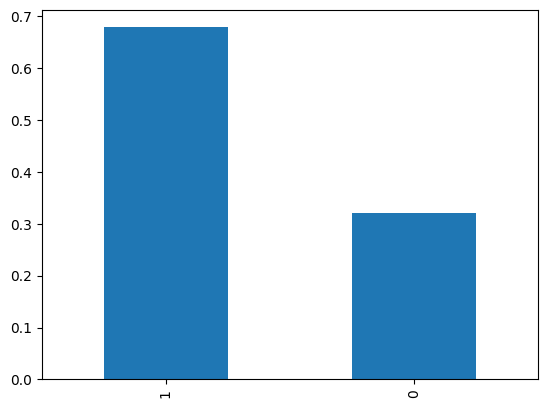

In [79]:
data_train['Target'].value_counts(normalize=True).plot(kind='bar')

In [80]:
data_train[(data_train['Gender']>0) & (data_train['Gender']<1)]

,Driver_ID,ReportingDate,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Dateofjoining,LastWorkingDate,Total Business Value,Quarterly Rating,Quarterly_Rating_Increased,Target,Monthly_Income_Increased,Tenure
100,119,2020-03-01,32.0,0.6,C29,1.0,71000.0,3.0,3.0,2019-11-16,2020-03-24,557720.0,1.0,0,1,0,3
854,1004,2019-05-01,31.0,0.8,C14,0.0,58588.0,2.0,2.0,2018-11-18,2019-05-02,424460.0,1.0,0,1,0,5
969,1143,2019-11-01,32.0,0.2,C29,2.0,30860.0,1.0,2.0,2018-05-14,2019-11-07,3605360.0,1.0,0,1,0,17
2225,2607,2019-05-01,40.0,0.6,C17,1.0,21636.0,1.0,1.0,2018-12-24,2019-05-07,953760.0,1.0,0,1,0,4
2362,2765,2019-02-01,26.0,0.8,C18,1.0,38809.0,1.0,1.0,2018-10-02,2019-02-23,0.0,1.0,0,1,0,4


In [81]:
data_train.at[2362, 'Gender'] = 1
data_train.at[100, 'Gender'] = 0
data_train.at[854, 'Gender'] = 0
data_train.at[969, 'Gender'] = 0
data_train.at[2225, 'Gender'] = 0

In [82]:
# unique values, value counts and proportion in categorical features
for i in data_train.columns:
    if data_train[i].nunique()<30:
        print(i, ':\n', np.sort(data_train[i].unique()))
        df0 = pd.DataFrame(data_train[i].value_counts()).reset_index()
        df0 = df0.rename(columns={"index": i, i: "value_counts"})
        df1 = pd.DataFrame((data_train[i].value_counts(normalize=True)).round(3)*100).reset_index(drop=True)
        df1 = df1.rename(columns={i: "proportion (%)"})
        df_concat = pd.concat([df0, df1], axis=1)
        print()
        print(df_concat)
        print('=======================================================================')

ReportingDate :
 ['2019-01-01T00:00:00.000000000' '2019-02-01T00:00:00.000000000'
 '2019-03-01T00:00:00.000000000' '2019-04-01T00:00:00.000000000'
 '2019-05-01T00:00:00.000000000' '2019-06-01T00:00:00.000000000'
 '2019-07-01T00:00:00.000000000' '2019-08-01T00:00:00.000000000'
 '2019-09-01T00:00:00.000000000' '2019-10-01T00:00:00.000000000'
 '2019-11-01T00:00:00.000000000' '2019-12-01T00:00:00.000000000'
 '2020-01-01T00:00:00.000000000' '2020-02-01T00:00:00.000000000'
 '2020-03-01T00:00:00.000000000' '2020-04-01T00:00:00.000000000'
 '2020-05-01T00:00:00.000000000' '2020-06-01T00:00:00.000000000'
 '2020-07-01T00:00:00.000000000' '2020-08-01T00:00:00.000000000'
 '2020-09-01T00:00:00.000000000' '2020-10-01T00:00:00.000000000'
 '2020-11-01T00:00:00.000000000' '2020-12-01T00:00:00.000000000']

   ReportingDate  value_counts  proportion (%)
0     2020-12-01           819            34.4
1     2019-05-01           101             4.2
2     2019-09-01            90             3.8
3     2020-07

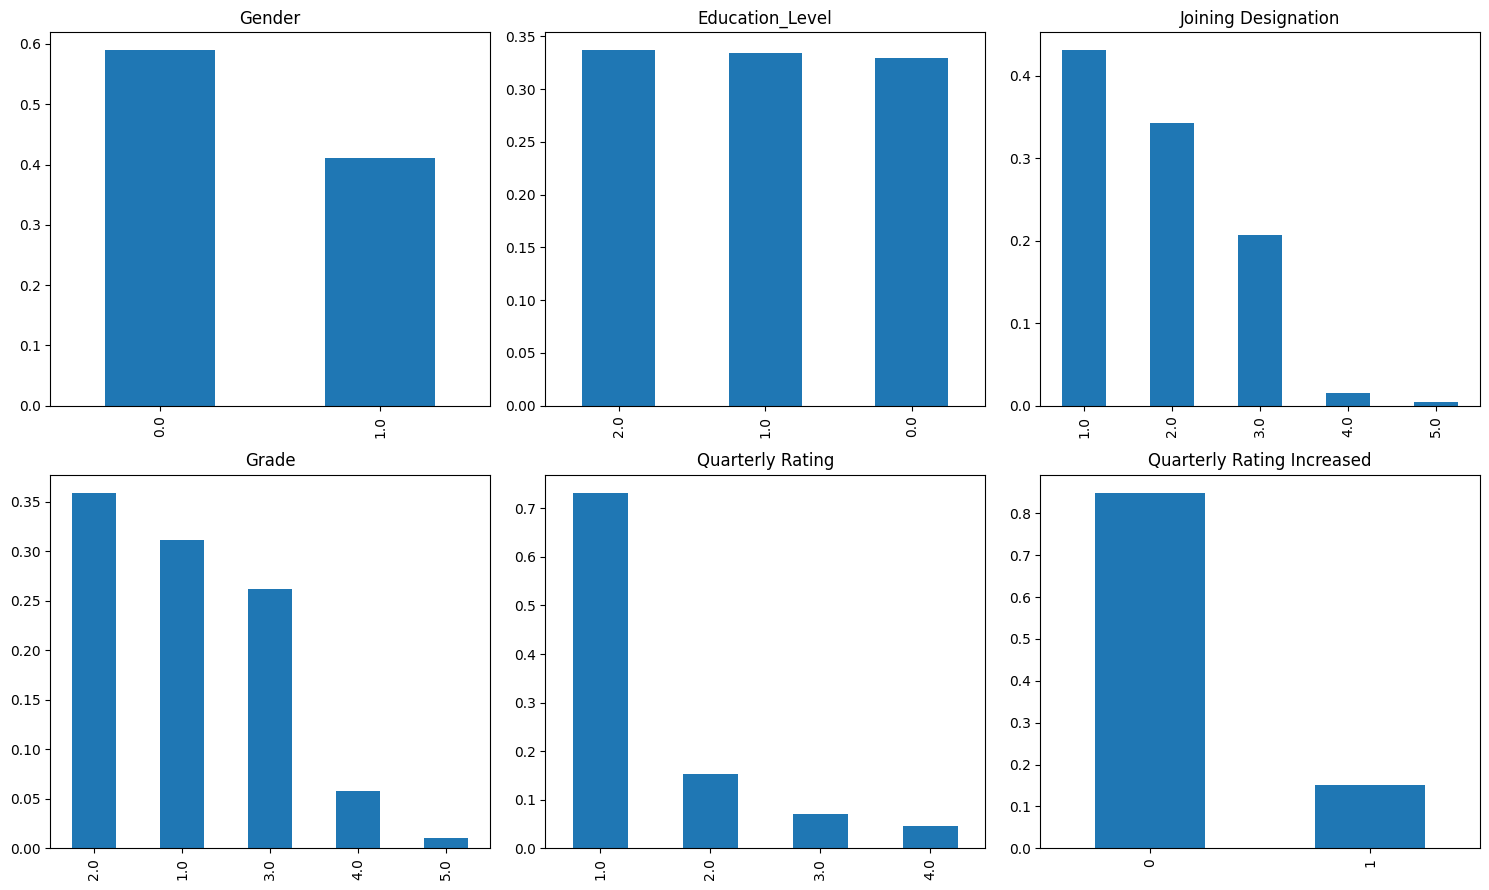

In [83]:
figure,axes=plt.subplots(2,3,figsize=(15,9))
plt.subplot(231)
data_train['Gender'].value_counts(normalize=True).plot.bar(title='Gender')

plt.subplot(232)
data_train['Education_Level'].value_counts(normalize=True).plot.bar(title='Education_Level')

plt.subplot(233)
data_train['Joining Designation'].value_counts(normalize=True).plot.bar(title='Joining Designation')

plt.subplot(234)
data_train['Grade'].value_counts(normalize=True).plot.bar(title='Grade')

plt.subplot(235)
data_train['Quarterly Rating'].value_counts(normalize=True).plot.bar(title='Quarterly Rating')

plt.subplot(236)
data_train['Quarterly_Rating_Increased'].value_counts(normalize=True).plot.bar(title='Quarterly Rating Increased')
plt.tight_layout()

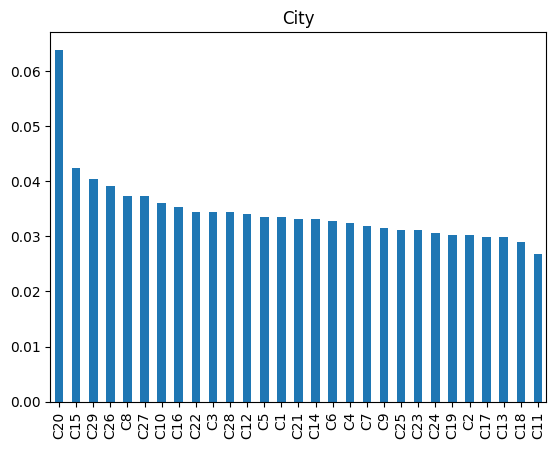

In [84]:
data_train['City'].value_counts(normalize=True).plot.bar(title='City')
plt.show()

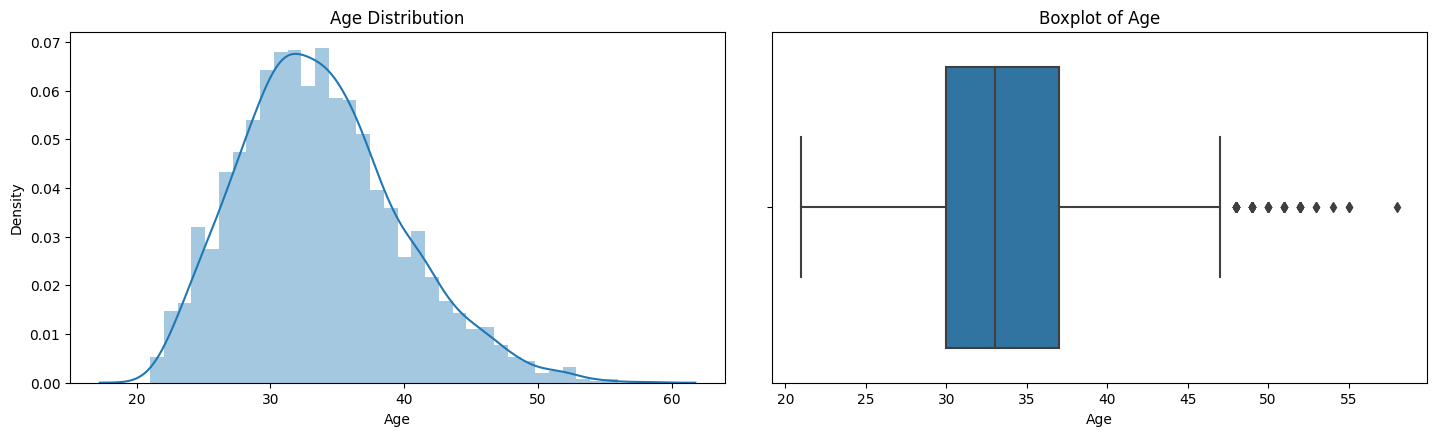

In [85]:
figure,axes=plt.subplots(1,2,figsize=(15,5))
plt.subplot(121)
sns.distplot(data_train['Age'])
plt.title("Age Distribution")
plt.subplot(122)
sns.boxplot(data_train, x='Age')
plt.title("Boxplot of Age")
plt.tight_layout(pad=3)

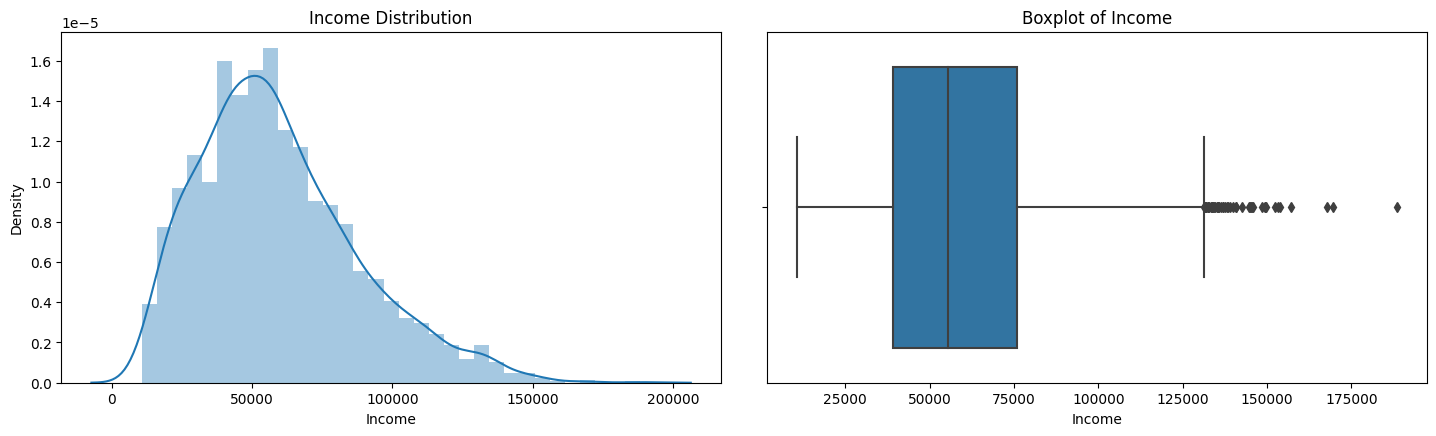

In [86]:
figure,axes=plt.subplots(1,2,figsize=(15,5))
plt.subplot(121)
sns.distplot(data_train['Income'])
plt.title("Income Distribution")
plt.subplot(122)
sns.boxplot(data_train, x='Income')
plt.title('Boxplot of Income')
plt.tight_layout(pad=3)

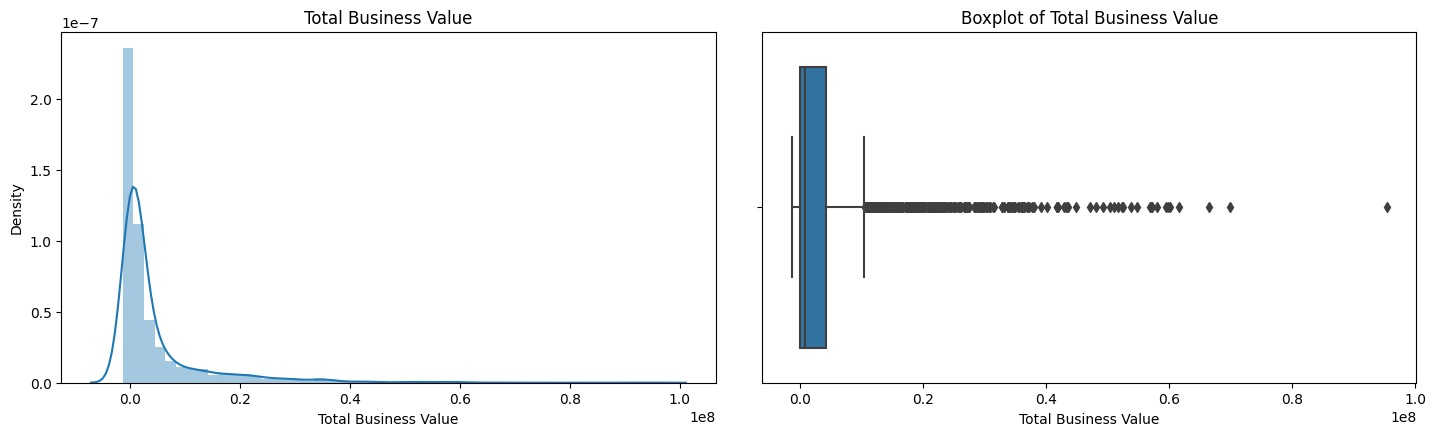

In [87]:
figure,axes=plt.subplots(1,2,figsize=(15,5))
plt.subplot(121)
sns.distplot(data_train['Total Business Value'])
plt.title("Total Business Value")
plt.subplot(122)
sns.boxplot(data_train, x='Total Business Value')
plt.title('Boxplot of Total Business Value')
plt.tight_layout(pad=3)

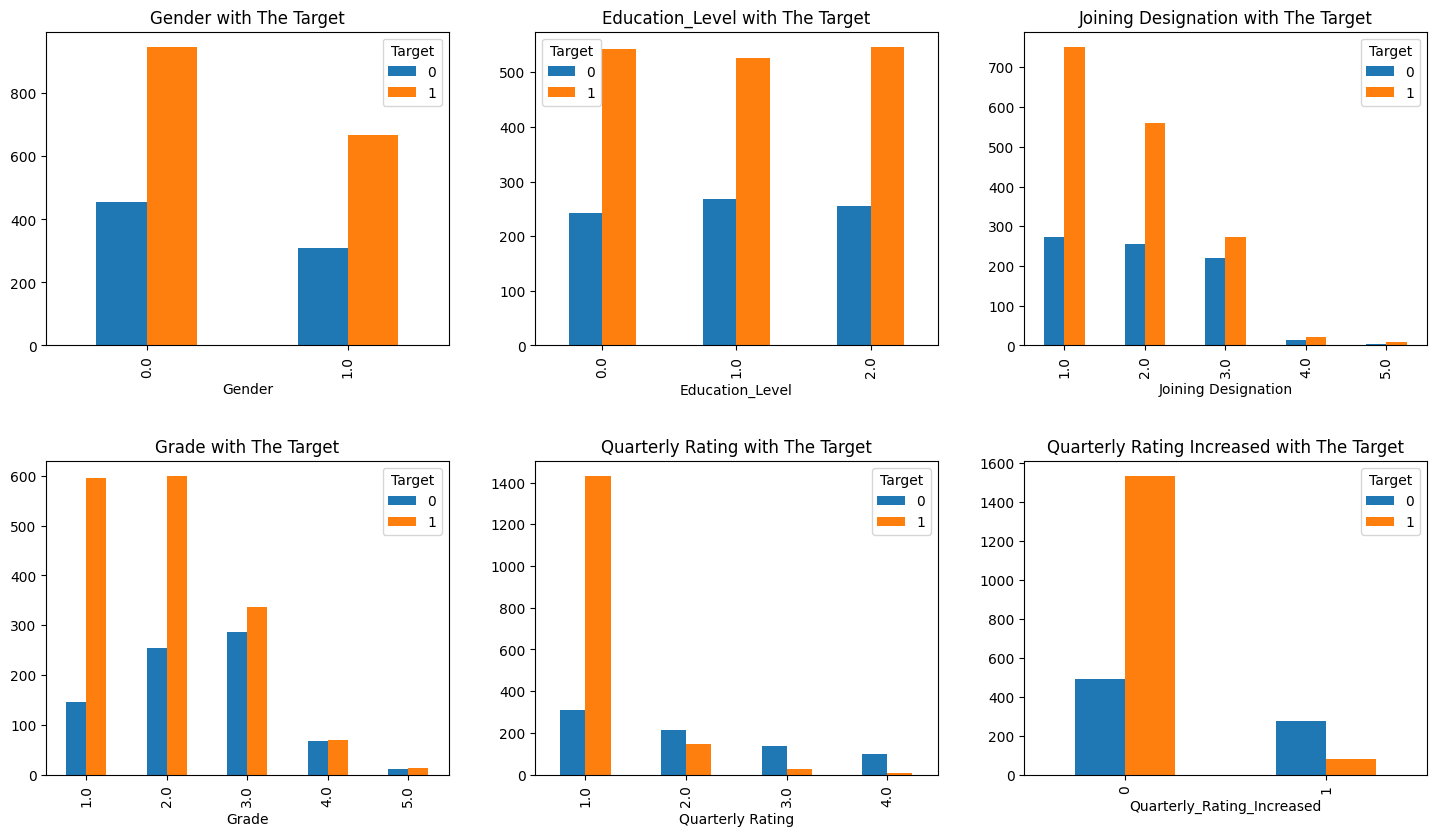

In [88]:
figure,axes=plt.subplots(2,3,figsize=(15,9))

# Gender feature with Target
pd.crosstab(data_train['Gender'],data_train['Target']).plot(kind='bar', ax=axes[0,0], title='Gender with The Target')

# Education_Level feature with Target
pd.crosstab(data_train['Education_Level'],data_train['Target']).plot(kind='bar', ax=axes[0,1], title='Education_Level with The Target')

# Joining Designation feature with Target
pd.crosstab(data_train['Joining Designation'],data_train['Target']).plot(kind='bar', ax=axes[0,2], title='Joining Designation with The Target')

# Grade feature with Target
pd.crosstab(data_train['Grade'],data_train['Target']).plot(kind='bar', ax=axes[1,0], title='Grade with The Target')

# Quarterly Rating feature with Target
pd.crosstab(data_train['Quarterly Rating'],data_train['Target']).plot(kind='bar', ax=axes[1,1], title='Quarterly Rating with The Target')

# Quarterly Rating Increased feature with Target
pd.crosstab(data_train['Quarterly_Rating_Increased'],data_train['Target']).plot(kind='bar', ax=axes[1,2], title='Quarterly Rating Increased with The Target')

plt.tight_layout(pad=3)

<Figure size 1500x800 with 0 Axes>

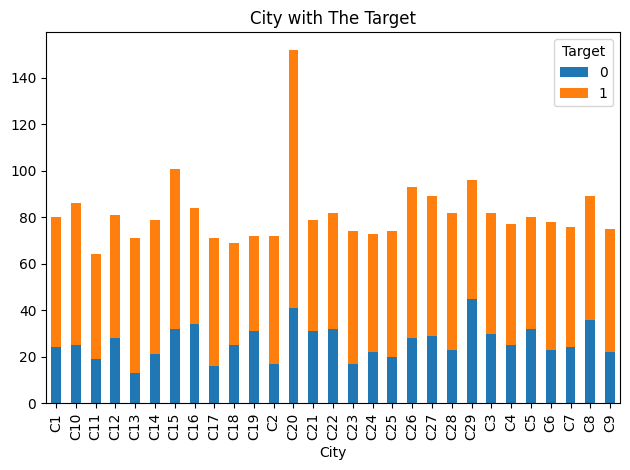

In [89]:
#City feature with the target
plt.figure(figsize=(15,8))
pd.crosstab(data_train['City'],data_train['Target']).plot(kind='bar', stacked=True, title='City with The Target')
plt.tight_layout()

<AxesSubplot: title={'center': 'Age with Target'}, xlabel='Age_Bin'>

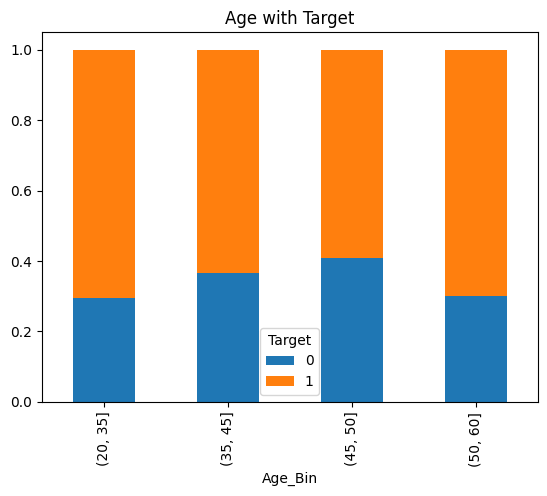

In [90]:
#Binning the Age into categories
data_train['Age_Bin'] = pd.cut(data_train['Age'],bins=[20,35,45,50,60])

# Age feature with Target
pd.crosstab(data_train['Age_Bin'],data_train['Target'], normalize='index').plot(kind='bar',stacked=True, title="Age with Target")

<AxesSubplot: title={'center': 'Income with Target'}, xlabel='Income_Bin'>

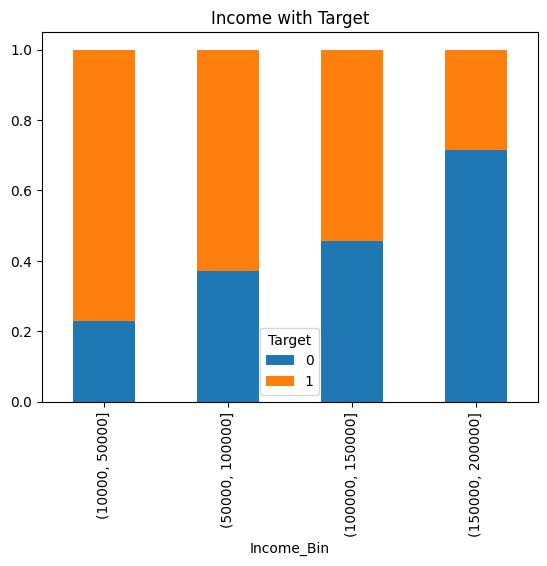

In [91]:
# Binning the Income into categories
data_train['Income_Bin'] = pd.cut(data_train['Income'],bins=[10000, 50000, 100000, 150000, 200000 ])

# Income feature with Target
pd.crosstab(data_train['Income_Bin'],data_train['Target'], normalize='index').plot(kind='bar',stacked=True, title="Income with Target")

<AxesSubplot: title={'center': 'Total Business Value with Target'}, xlabel='TBV_Bin'>

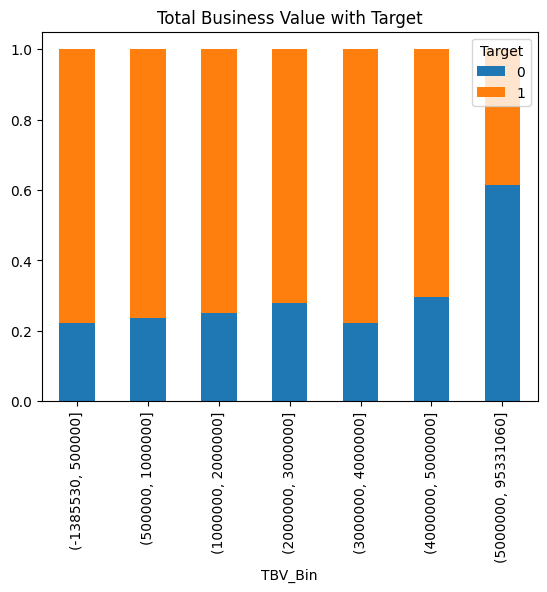

In [92]:
# Defining the bins and groups
min_ = round(data_train['Total Business Value'].min())
max_ = round(data_train['Total Business Value'].max())
bins = [min_, 500000 , 1000000 , 2000000, 3000000, 4000000, 5000000, max_]

#Binning the Total Business Value into categories
data_train['TBV_Bin'] = pd.cut(data_train['Total Business Value'], bins)

#Total Business Value feature with Target
pd.crosstab(data_train['TBV_Bin'],data_train['Target'], normalize='index').plot(kind='bar',stacked=True, title="Total Business Value with Target")

## Check correlation among independent variables and how they interact with each other

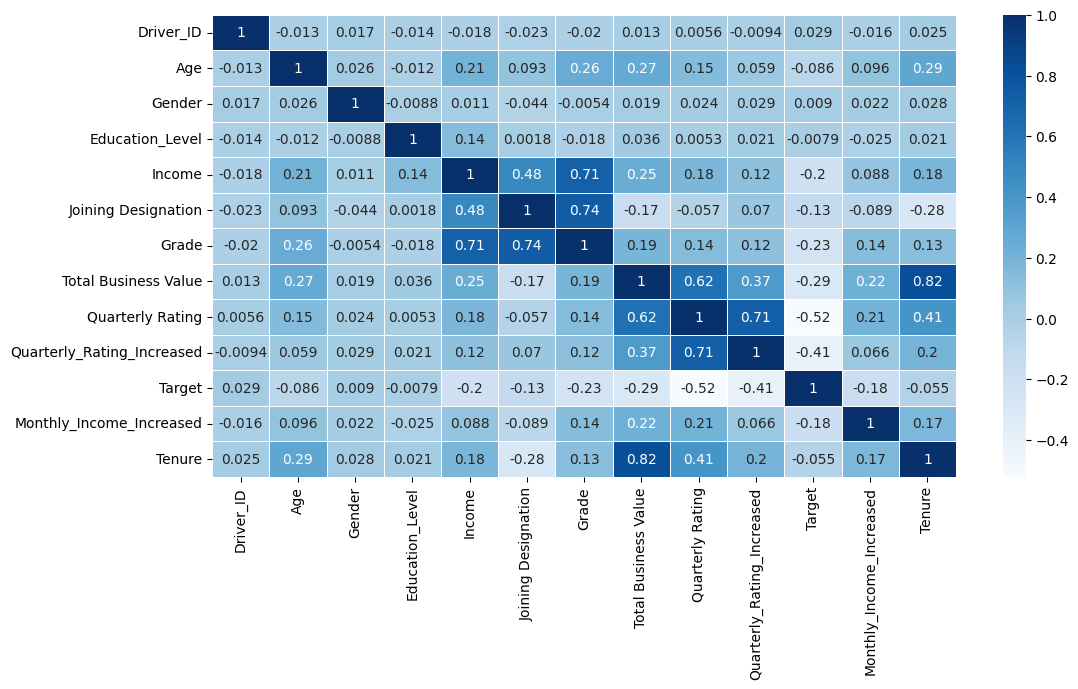

In [93]:
plt.figure(figsize=(12,6))
correlations = data_train.corr(method='spearman')
sns.heatmap(correlations, annot=True, linewidths=0.5, cmap='Blues')
plt.show()

<AxesSubplot: xlabel='Income', ylabel='Age'>

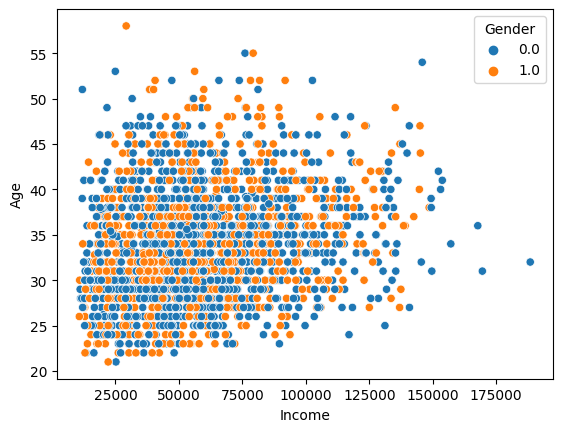

In [94]:
sns.scatterplot(data_train, x='Income', y='Age', hue='Gender')

<AxesSubplot: xlabel='Income', ylabel='Age'>

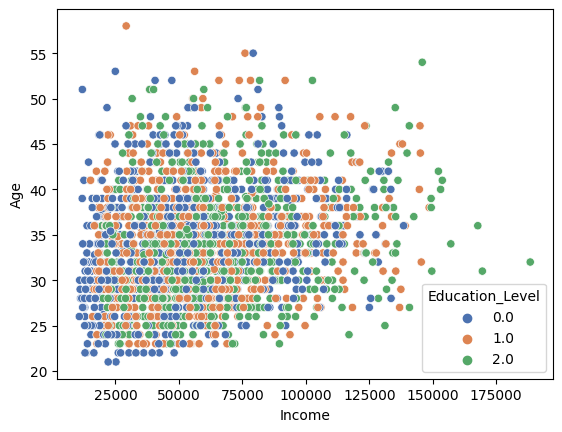

In [95]:
sns.scatterplot(data_train, x='Income', y='Age', hue='Education_Level', palette="deep")

<AxesSubplot: xlabel='Total Business Value', ylabel='Income'>

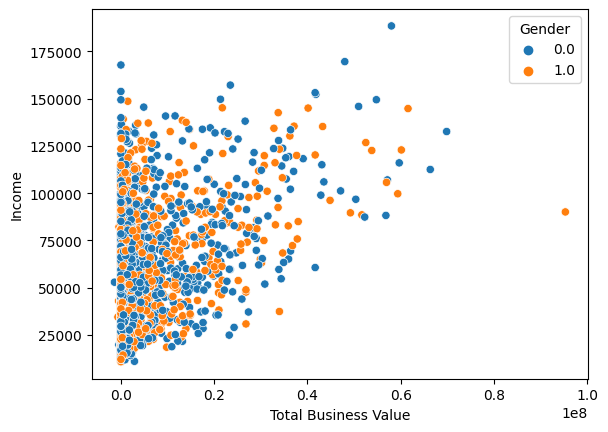

In [96]:
sns.scatterplot(data_train, x='Total Business Value', y='Income', hue='Gender')

<AxesSubplot: xlabel='Total Business Value', ylabel='Income'>

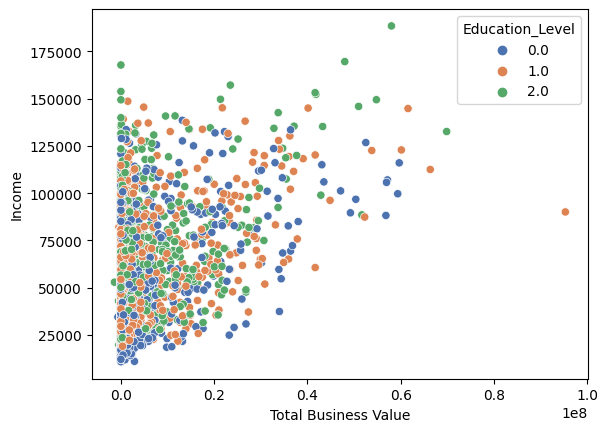

In [97]:
sns.scatterplot(data_train, x='Total Business Value', y='Income', hue='Education_Level', palette="deep")

<AxesSubplot: xlabel='Total Business Value', ylabel='Tenure'>

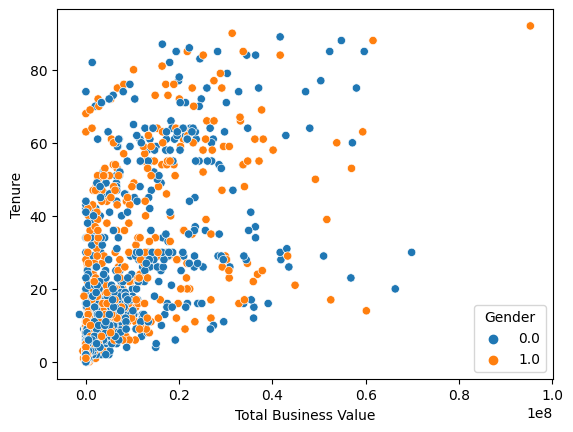

In [98]:
sns.scatterplot(data_train, x='Total Business Value', y='Tenure', hue='Gender')

<AxesSubplot: xlabel='Age'>

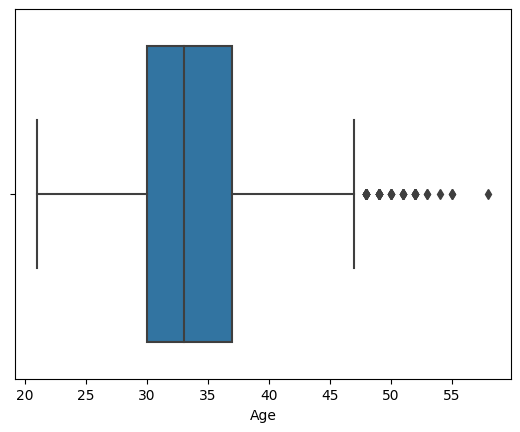

In [99]:
sns.boxplot(data_train, x='Age')

<AxesSubplot: xlabel='Target', ylabel='count'>

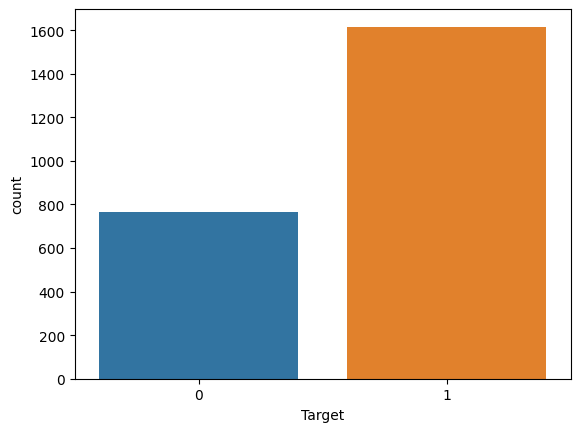

In [100]:
sns.countplot(data_train, x='Target')

__Observations:__

- There are total 2381 employees in the given data set out of which majority of drivers are male.
- Minimum age is 21 years and maximum age is 58 years for the drivers in given data set.
- 75% of the employees have their monthly income less than or equal to 75,986 units.
- 50% of the employees have acquired 8,17,680 as the their total business value.
- Most of the employees in the dataset were male, lived in C20 city and have completed their Masters in education.
- Out of 2381 employees, 1616 employees have left the organization. Around 68% employees have left the organization.
- Out of 2381 employees, 1404 employees are of the Male gender and 977 are females.
- Out of 2381 employees, 152 employees are from city C20 and 101 from city C15.
- Out of 2381 employees, 802 employees have their education as Graduate and 795 have completed their 12.
- Out of 2381 employees, 1026 joined with the grade as 1, 815 employees joined with the grade 2.
- Out of 2381 employees, 855 employees had their designation as 2 at the time of reporting.
- Out of 2381 employees, 1744 employees had their last quarterly rating as 1.
- Out of 2381 employees, the quarterly rating has not increased for 2076 employees.
- Around 59% employees are of the Male gender.
- Around 6.4% employees are from city C20 and 4.2% from city C15.
- The proportion of the employees who have completed their Graduation, 12th+ and 10th+ is approximately same.
- Around 43% of the employees joined with the grade 1.
- At the time of reporting, 36% of the employees had their grade as 2.
- Around 73% of the employees had their last quarterly rating as 1.
- The quarterly rating has not increased for around 85% employees.
- Less than 2% employees have monthly income increased.
- There are few outliers in the Age. The distribution is towards the right.
- The distribution of Salary is towards the right and there are outliers for this feature as well.
- The distribution of total business value is towards the right. There are a lot of outliers for the feature Total Business Value.
- The proportion of gender and education is more or less the same for both the employees who left the organization and those who did not leave.
- The employees who have their grade as 3 or 4 at the time of joining are less likely to leave the organization.
- The employees who have their grade as 3 or 4 at the time of reporting are less likely to leave the organization.
- The employees who have their last quarterly rating as 3 or 4 at the time of reporting are less likely to leave the organization.
- The employees whose quarterly rating has increased are less likely to leave the organization.
- The employees whose age is in the 20-35 or 50-65 groups are more likely to leave the organization.
- The employees whose monthly income more than 1,50,000 units are less likely to leave the organization.
- The employees who have acquired total business value greater than 50,00,000 are less likely to leave the organization.

In [101]:
# Dropping the bins columns
data_train.drop(['Age_Bin','Income_Bin','TBV_Bin'], axis=1, inplace=True)

In [102]:
# Dropping the date columns
data_train.drop(['ReportingDate','Dateofjoining','LastWorkingDate'], axis=1, inplace=True)

In [103]:
data_train

,Driver_ID,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,Quarterly_Rating_Increased,Target,Monthly_Income_Increased,Tenure
0,1,28.0,0.0,C23,2.0,57387.0,1.0,1.0,1715580.0,2.0,0,1,0,2
1,2,31.0,0.0,C7,2.0,67016.0,2.0,2.0,0.0,1.0,0,0,0,0
2,4,43.0,0.0,C13,2.0,65603.0,2.0,2.0,350000.0,1.0,0,1,0,3
3,5,29.0,0.0,C9,0.0,46368.0,1.0,1.0,120360.0,1.0,0,1,0,1
4,6,31.0,1.0,C11,1.0,78728.0,3.0,3.0,1265000.0,2.0,1,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,2784,34.0,0.0,C24,0.0,82815.0,2.0,3.0,21748820.0,4.0,1,0,0,61
2377,2785,34.0,1.0,C9,0.0,12105.0,1.0,1.0,0.0,1.0,0,1,0,1
2378,2786,45.0,0.0,C19,0.0,35370.0,2.0,2.0,2815090.0,1.0,0,1,0,13
2379,2787,28.0,1.0,C20,2.0,69498.0,1.0,1.0,977830.0,1.0,0,1,0,10


## One hot encoding of the categorical variable

In [104]:
# encoding of city column
data_train = pd.concat([data_train, pd.get_dummies(data_train['City'], prefix='City')], axis=1)
data_train

,Driver_ID,Age,Gender,City,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,...,City_C27,City_C28,City_C29,City_C3,City_C4,City_C5,City_C6,City_C7,City_C8,City_C9
0,1,28.0,0.0,C23,2.0,57387.0,1.0,1.0,1715580.0,2.0,...,0,0,0,0,0,0,0,0,0,0
1,2,31.0,0.0,C7,2.0,67016.0,2.0,2.0,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0
2,4,43.0,0.0,C13,2.0,65603.0,2.0,2.0,350000.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,5,29.0,0.0,C9,0.0,46368.0,1.0,1.0,120360.0,1.0,...,0,0,0,0,0,0,0,0,0,1
4,6,31.0,1.0,C11,1.0,78728.0,3.0,3.0,1265000.0,2.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,2784,34.0,0.0,C24,0.0,82815.0,2.0,3.0,21748820.0,4.0,...,0,0,0,0,0,0,0,0,0,0
2377,2785,34.0,1.0,C9,0.0,12105.0,1.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
2378,2786,45.0,0.0,C19,0.0,35370.0,2.0,2.0,2815090.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2379,2787,28.0,1.0,C20,2.0,69498.0,1.0,1.0,977830.0,1.0,...,0,0,0,0,0,0,0,0,0,0


## Standardization of training data

In [106]:
# For minmaxscaler
from sklearn.preprocessing import MinMaxScaler

# Feature Variables
X_features = data_train.drop(['Driver_ID','Target','City'], axis=1)
feature_cols = X_features.columns

# MinMaxScaler
scaler = MinMaxScaler()

# Scaled Feature Variables
X_scaled = scaler.fit_transform(X_features)
X_scaled = pd.DataFrame(X_scaled)
X_scaled.columns = feature_cols
X_scaled

,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,Quarterly_Rating_Increased,Monthly_Income_Increased,...,City_C27,City_C28,City_C29,City_C3,City_C4,City_C5,City_C6,City_C7,City_C8,City_C9
0,0.189189,0.0,1.0,0.262508,0.00,0.00,0.032064,0.333333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.270270,0.0,1.0,0.316703,0.25,0.25,0.014326,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.594595,0.0,1.0,0.308750,0.25,0.25,0.017944,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.216216,0.0,0.0,0.200489,0.00,0.00,0.015570,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.270270,1.0,0.5,0.382623,0.50,0.50,0.027405,0.333333,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,0.351351,0.0,0.0,0.405626,0.25,0.50,0.239197,1.000000,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2377,0.351351,1.0,0.0,0.007643,0.00,0.00,0.014326,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2378,0.648649,0.0,0.0,0.138588,0.25,0.25,0.043432,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2379,0.189189,1.0,1.0,0.330673,0.00,0.00,0.024436,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
# Target Variable
y = data_train['Target']
y

0       1
1       0
2       1
3       1
4       0
       ..
2376    0
2377    1
2378    1
2379    1
2380    0
Name: Target, Length: 2381, dtype: int64

In [108]:
# For train-test split & Hyperparameter tuning 
from sklearn.model_selection import train_test_split, GridSearchCV

# Split data into Train & Test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42)

In [109]:
# shape of Train & test sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1904, 40), (477, 40), (1904,), (477,))

## Class Imbalance Treatment

__Oversampling minority class using SMOTE__

In [110]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

In [111]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

After OverSampling, the shape of train_X: (2578, 40)
After OverSampling, the shape of train_y: (2578,) 

After OverSampling, counts of label '1': 1289
After OverSampling, counts of label '0': 1289


## Using Ensemble learning - Bagging, Boosting methods with some hyper-parameter tuning

### Random Forest Classifier on balanced dataset

In [112]:
# For Random Forest
from sklearn.ensemble import RandomForestClassifier

# For model validation
from sklearn import metrics
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, classification_report, precision_recall_curve,\
                             roc_auc_score, roc_curve, auc,plot_confusion_matrix, plot_roc_curve, ConfusionMatrixDisplay)

Best parameters are : {'max_depth': 10, 'n_estimators': 80}
The score is : 0.8616161862685038


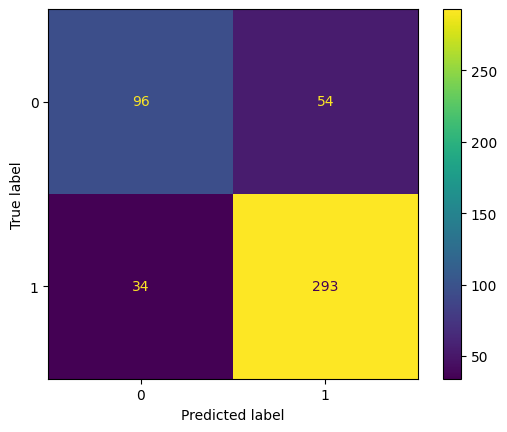

In [127]:
param = {'max_depth':[2,3,4,5,8,10], 'n_estimators':[10,20,50,80,100,150,200]}

model_RF = RandomForestClassifier()

tuned_model_RF = GridSearchCV(model_RF, param, cv=5, scoring='f1')
tuned_model_RF.fit(X_train_res, y_train_res)

def display(results):
    print(f'Best parameters are : {results.best_params_}')
    print(f'The score is : {results.best_score_}')

display(tuned_model_RF)

y_pred = tuned_model_RF.predict(X_test)
   
cm = confusion_matrix(y_test, y_pred)
dispCM = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tuned_model_RF.classes_)
dispCM.plot(cmap='viridis')
plt.show()

__Results Evaluation for Random Forest with balanced dataset:__

In [129]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.64      0.69       150
           1       0.84      0.90      0.87       327

    accuracy                           0.82       477
   macro avg       0.79      0.77      0.78       477
weighted avg       0.81      0.82      0.81       477



- For Random Forest on balanced data, out of all predicted 0 the measure of correctly predicted is 74%, and for 1 it is 84% (Precision).
- For Random Forest on balanced data, out of all actual 0 the measure of correctly predicted is 64%, and for 1 it is 90% (Recall).

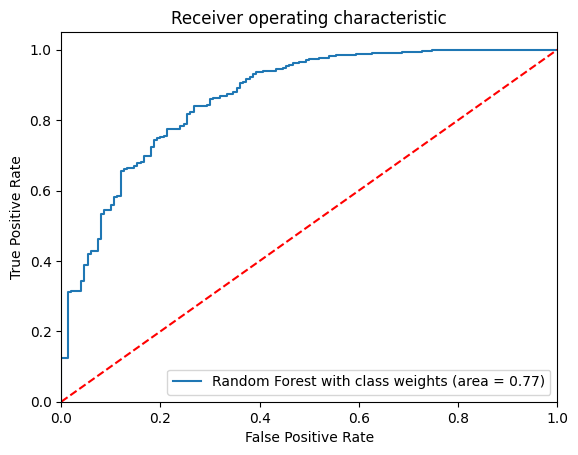

In [130]:
# ROC AUC curve
RF_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, tuned_model_RF.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest with class weights (area = %0.2f)' % RF_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

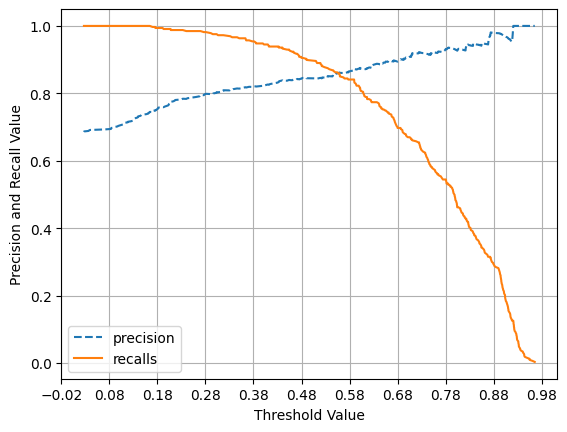

In [131]:
# Precision recall curve
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    threshold_boundary = thresholds.shape[0]
    # plot precision
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    # plot recall
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recalls')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold Value') 
    plt.ylabel('Precision and Recall Value')
    plt.legend()
    plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, tuned_model_RF.predict_proba(X_test)[:,1])

### Random Forest with class weights on imbalanced dataset

In [114]:
from sklearn.utils import class_weight

Best parameters are : {'max_depth': 8, 'n_estimators': 200}
The score is : 0.8747497743002317


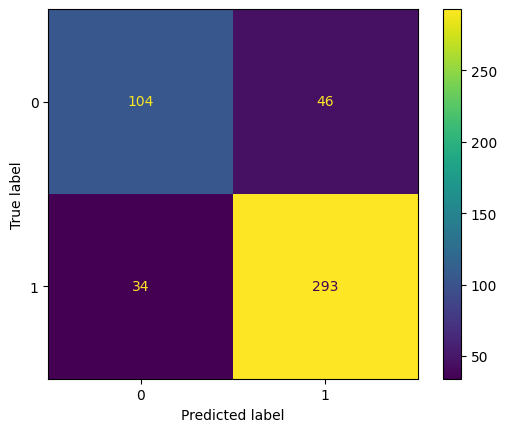

In [123]:
param = {'max_depth':[2,3,4,5,8,10], 'n_estimators':[10,20,50,80,100,150,200]}

model_RF_cw = RandomForestClassifier(class_weight ='balanced')

tuned_model_RF_cw = GridSearchCV(model_RF_cw, param, cv=5, scoring='f1')
tuned_model_RF_cw.fit(X_train, y_train)

def display(results):
    print(f'Best parameters are : {results.best_params_}')
    print(f'The score is : {results.best_score_}')

display(tuned_model_RF_cw)

y_pred = tuned_model_RF_cw.predict(X_test)
   
cm = confusion_matrix(y_test, y_pred)
dispCM = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tuned_model_RF_cw.classes_)
dispCM.plot(cmap='viridis')
plt.show()

__Results Evaluation for Random Forest with class weights:__

In [124]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.69      0.72       150
           1       0.86      0.90      0.88       327

    accuracy                           0.83       477
   macro avg       0.81      0.79      0.80       477
weighted avg       0.83      0.83      0.83       477



- The Random Forest With Class Weighting method out of all predicted 0 the measure of correctly predicted is 75%, and for 1 it is 86% (Precision).
- The Random Forest With Class Weighting method out of all actual 0 the measure of correctly predicted is 69%, and for 1 it is 90% (Recall).

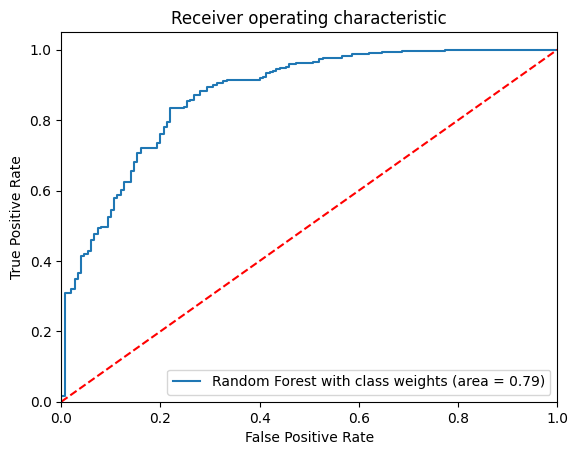

In [125]:
# ROC AUC curve
RF_cw_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, tuned_model_RF_cw.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest with class weights (area = %0.2f)' % RF_cw_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

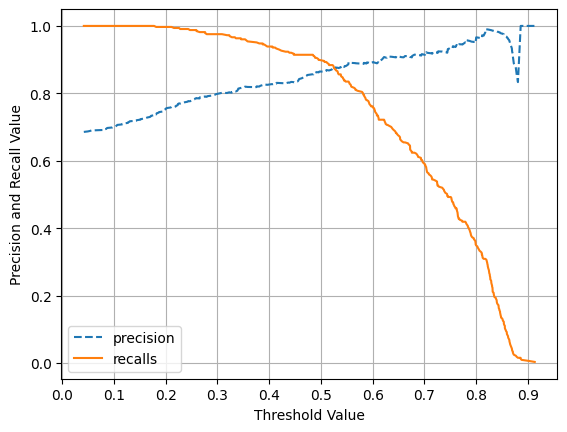

In [126]:
# Precision recall curve
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    threshold_boundary = thresholds.shape[0]
    # plot precision
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    # plot recall
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recalls')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold Value') 
    plt.ylabel('Precision and Recall Value')
    plt.legend()
    plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, tuned_model_RF_cw.predict_proba(X_test)[:,1])

### Random Forest bootstrap with class weights on imbalanced dataset

Best parameters are : {'max_depth': 10, 'n_estimators': 200}
The score is : 0.8760313131533739


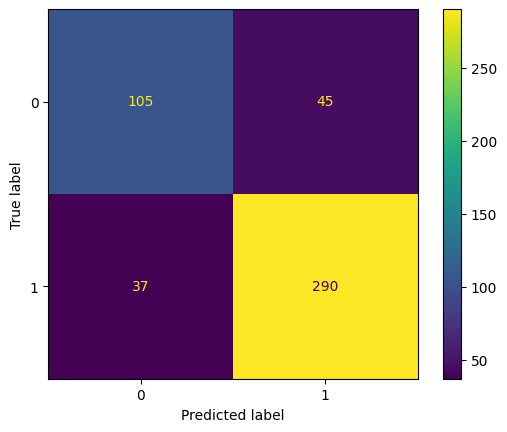

In [132]:
param = {'max_depth':[2,3,4,5,8,10], 'n_estimators':[10,20,50,80,100,150,200]}

model_RF_bscw = RandomForestClassifier(class_weight ='balanced_subsample')

tuned_model_RF_bscw = GridSearchCV(model_RF_bscw, param, cv=5, scoring='f1')
tuned_model_RF_bscw.fit(X_train, y_train)

def display(results):
    print(f'Best parameters are : {results.best_params_}')
    print(f'The score is : {results.best_score_}')

display(tuned_model_RF_bscw)

y_pred = tuned_model_RF_bscw.predict(X_test)
   
cm = confusion_matrix(y_test, y_pred)
dispCM = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tuned_model_RF_bscw.classes_)
dispCM.plot(cmap='viridis')
plt.show()

__Results Evaluation for Random Forest bootstrap with class weights:__

In [133]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.70      0.72       150
           1       0.87      0.89      0.88       327

    accuracy                           0.83       477
   macro avg       0.80      0.79      0.80       477
weighted avg       0.83      0.83      0.83       477



- The Random Forest With Bootstrap Class Weighting method out of all predicted 0 the measure of correctly predicted is 74%, and for 1 it is 87% (Precision).
- The Random Forest With Bootstrap Class Weighting method out of all actual 0 the measure of correctly predicted is 70%, and for 1 it is 89% (Recall).

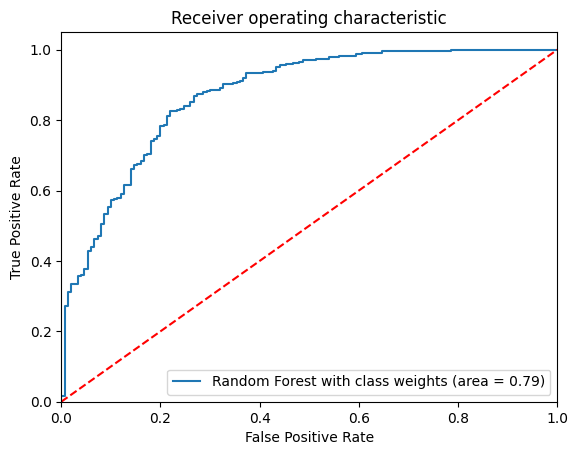

In [134]:
# ROC AUC curve
RF_bscw_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, tuned_model_RF_bscw.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest with class weights (area = %0.2f)' % RF_bscw_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

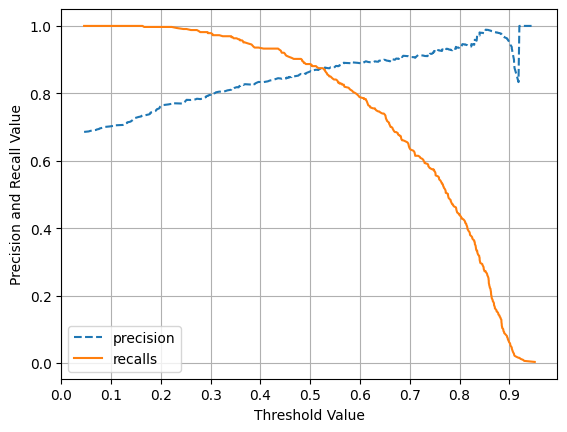

In [135]:
# Precision recall curve
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    threshold_boundary = thresholds.shape[0]
    # plot precision
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    # plot recall
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recalls')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold Value') 
    plt.ylabel('Precision and Recall Value')
    plt.legend()
    plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, tuned_model_RF_bscw.predict_proba(X_test)[:,1])

### XGBoost Classifier on balanced dataset

In [138]:
# For XGBoost classifier
import xgboost as xgb

Best parameters are : {'eta': 0.1, 'max_depth': 10}
The score is : 0.8669613227346021


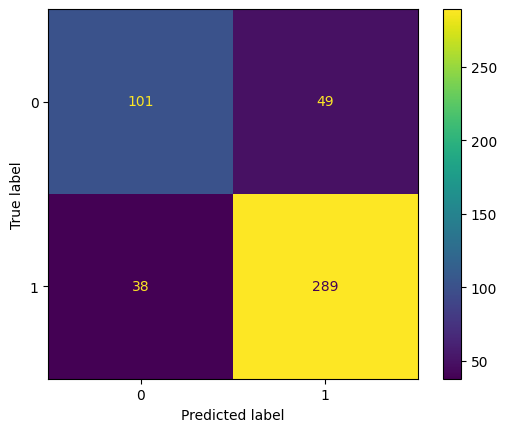

In [155]:
param = {'max_depth':[2,3,4,5,10], 'eta':[0.01,0.03,0.1,0.3,1.0]}

model_XGB = xgb.XGBClassifier(objective= 'binary:logistic')

tuned_model_XGB = GridSearchCV(model_XGB, param, cv=5, scoring='f1')
tuned_model_XGB.fit(X_train_res, y_train_res)

def display(results):
    print(f'Best parameters are : {results.best_params_}')
    print(f'The score is : {results.best_score_}')

display(tuned_model_XGB)

y_pred = tuned_model_XGB.predict(X_test)
   
cm = confusion_matrix(y_test, y_pred)
dispCM = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tuned_model_XGB.classes_)
dispCM.plot(cmap='viridis')
plt.show()

__Results Evaluation for XGBoost with balanced dataset:__

In [156]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.67      0.70       150
           1       0.86      0.88      0.87       327

    accuracy                           0.82       477
   macro avg       0.79      0.78      0.78       477
weighted avg       0.81      0.82      0.82       477



- For XGBoost on balanced data, out of all predicted 0 the measure of correctly predicted is 73%, and for 1 it is 86% (Precision).
- For XGBoost on balanced data, out of all actual 0 the measure of correctly predicted is 67%, and for 1 it is 88% (Recall).

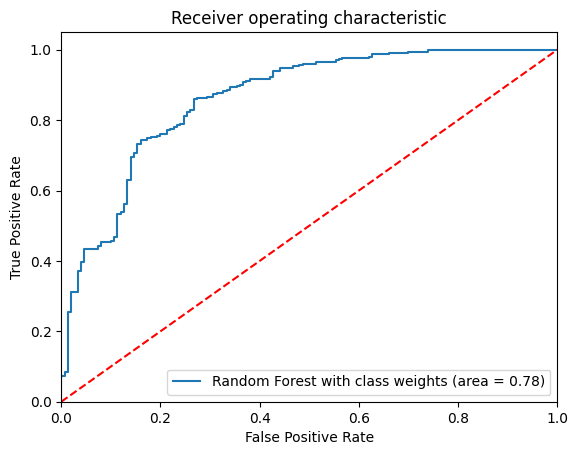

In [157]:
# ROC AUC curve
XGB_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, tuned_model_XGB.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest with class weights (area = %0.2f)' % XGB_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

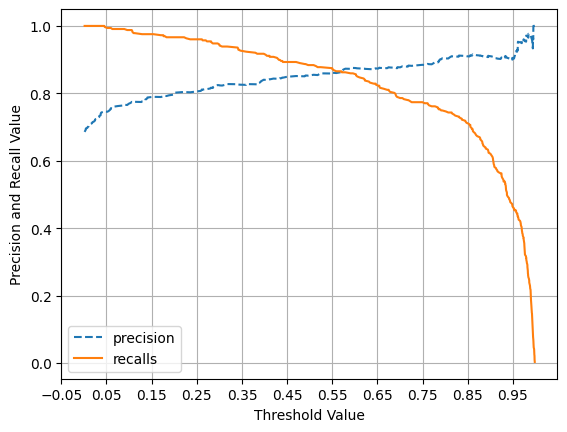

In [158]:
# Precision recall curve
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    threshold_boundary = thresholds.shape[0]
    # plot precision
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    # plot recall
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recalls')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold Value') 
    plt.ylabel('Precision and Recall Value')
    plt.legend()
    plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, tuned_model_XGB.predict_proba(X_test)[:,1])

### XGBoost Classifier with scale_pos_weight on imbalanced dataset

In [164]:
classes = data_train['Target'].value_counts()
classes

1    1616
0     765
Name: Target, dtype: int64

In [165]:
# scale_pos_weight = total_negative_examples / total_positive_examples
spw = classes[0] / classes[1]
spw

0.47339108910891087

Best parameters are : {'eta': 0.1, 'max_depth': 3}
The score is : 0.8721128970879191


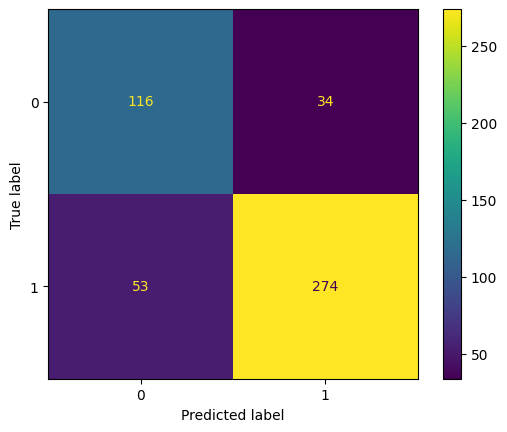

In [166]:
param = {'max_depth':[2,3,4,5,10], 'eta':[0.01,0.03,0.1,0.3,1.0]}

model_XGB_spw = xgb.XGBClassifier(objective= 'binary:logistic', scale_pos_weight=spw)

tuned_model_XGB_spw = GridSearchCV(model_XGB_spw, param, cv=5, scoring='f1')
tuned_model_XGB_spw.fit(X_train, y_train)

def display(results):
    print(f'Best parameters are : {results.best_params_}')
    print(f'The score is : {results.best_score_}')

display(tuned_model_XGB_spw)

y_pred = tuned_model_XGB_spw.predict(X_test)
   
cm = confusion_matrix(y_test, y_pred)
dispCM = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tuned_model_XGB_spw.classes_)
dispCM.plot(cmap='viridis')
plt.show()

__Results Evaluation for XGBoost with imbalanced dataset:__

In [167]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.77      0.73       150
           1       0.89      0.84      0.86       327

    accuracy                           0.82       477
   macro avg       0.79      0.81      0.80       477
weighted avg       0.83      0.82      0.82       477



- For XGBoost on imbalanced data, out of all predicted 0 the measure of correctly predicted is 69%, and for 1 it is 89% (Precision).
- For XGBoost on imbalanced data, out of all actual 0 the measure of correctly predicted is 77%, and for 1 it is 84% (Recall).

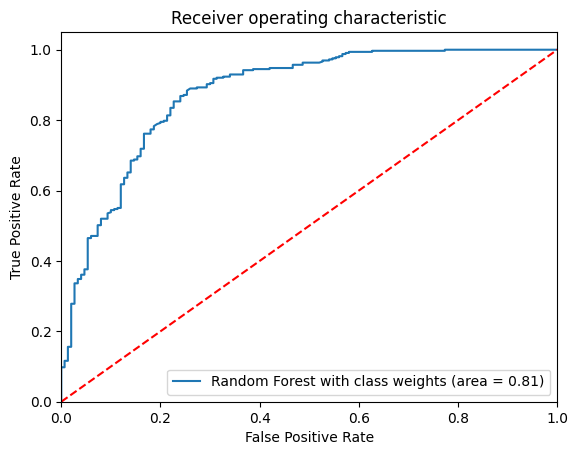

In [168]:
# ROC AUC curve
XGB_spw_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, tuned_model_XGB_spw.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest with class weights (area = %0.2f)' % XGB_spw_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

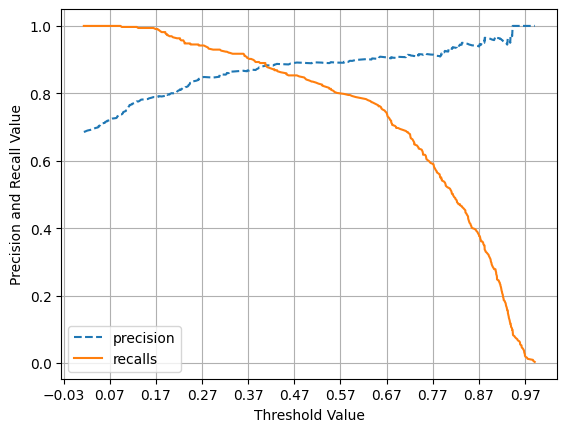

In [169]:
# Precision recall curve
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    threshold_boundary = thresholds.shape[0]
    # plot precision
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    # plot recall
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recalls')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold Value') 
    plt.ylabel('Precision and Recall Value')
    plt.legend()
    plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, tuned_model_XGB_spw.predict_proba(X_test)[:,1])

### Decision Tree Classifier on balanced dataset

In [170]:
# For Decision Tree
from sklearn.tree import DecisionTreeClassifier

Best parameters are : {'max_depth': 4, 'max_leaf_nodes': 8, 'min_samples_split': 2}
The score is : 0.8155951191888965


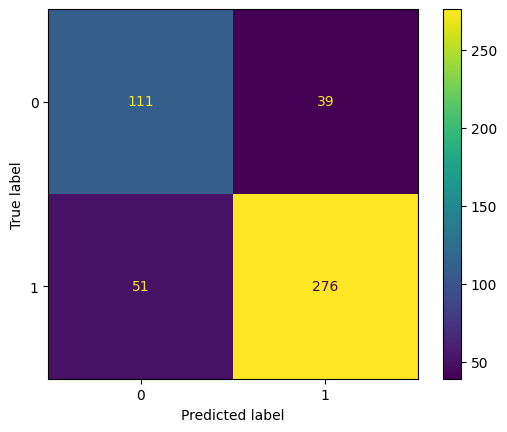

In [172]:
param = {'max_depth':[2,3,4,5,8,10], 'max_leaf_nodes':[2,3,4,5,8,10], 'min_samples_split':[2,5,10,20,50]}

model_DT = DecisionTreeClassifier()

tuned_model_DT = GridSearchCV(model_DT, param, cv=5, scoring='f1')
tuned_model_DT.fit(X_train_res, y_train_res)

def display(results):
    print(f'Best parameters are : {results.best_params_}')
    print(f'The score is : {results.best_score_}')

display(tuned_model_DT)

y_pred = tuned_model_DT.predict(X_test)
   
cm = confusion_matrix(y_test, y_pred)
dispCM = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tuned_model_DT.classes_)
dispCM.plot(cmap='viridis')
plt.show()

__Results Evaluation for Decision Tree with balanced dataset:__

In [174]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.74      0.71       150
           1       0.88      0.84      0.86       327

    accuracy                           0.81       477
   macro avg       0.78      0.79      0.79       477
weighted avg       0.82      0.81      0.81       477



- For Decision Tree on balanced data, out of all predicted 0 the measure of correctly predicted is 69%, and for 1 it is 88% (Precision).
- For Decision Tree on balanced data, out of all actual 0 the measure of correctly predicted is 74%, and for 1 it is 84% (Recall).

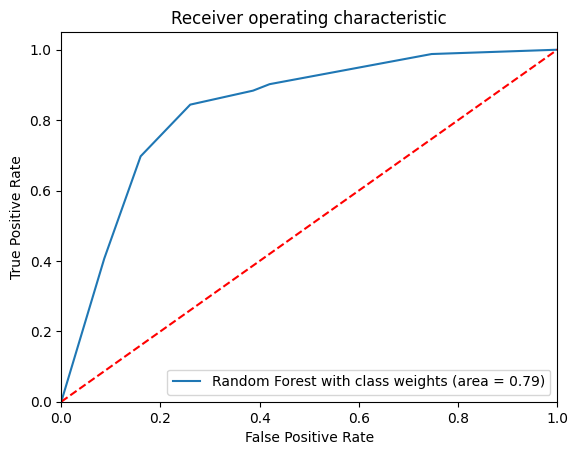

In [176]:
# ROC AUC curve
DT_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, tuned_model_DT.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest with class weights (area = %0.2f)' % DT_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

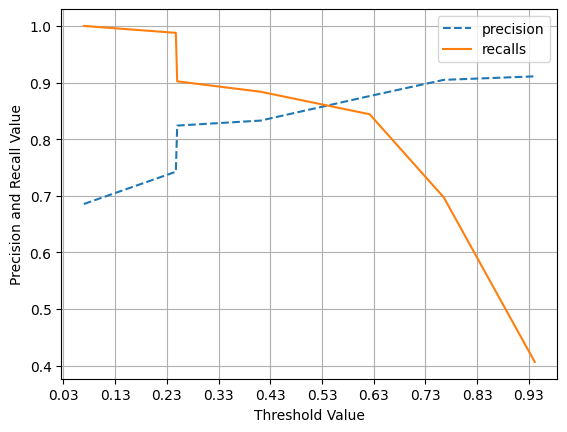

In [177]:
# Precision recall curve
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    threshold_boundary = thresholds.shape[0]
    # plot precision
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    # plot recall
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recalls')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold Value') 
    plt.ylabel('Precision and Recall Value')
    plt.legend()
    plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, tuned_model_DT.predict_proba(X_test)[:,1])

### Decision Tree Classifier with class weights on imbalanced dataset

Best parameters are : {'max_depth': 3, 'max_leaf_nodes': 8, 'min_samples_split': 2}
The score is : 0.857568987703068


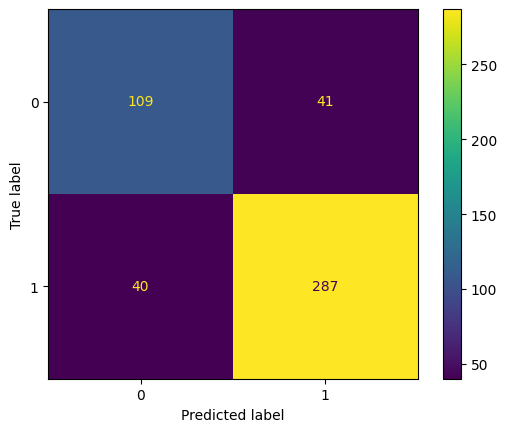

In [181]:
param = {'max_depth':[2,3,4,5,8,10], 'max_leaf_nodes':[2,3,4,5,8,10], 'min_samples_split':[2,5,10,20,50]}

model_DT_cw = DecisionTreeClassifier(class_weight='balanced')

tuned_model_DT_cw = GridSearchCV(model_DT_cw, param, cv=5, scoring='f1')
tuned_model_DT_cw.fit(X_train, y_train)

def display(results):
    print(f'Best parameters are : {results.best_params_}')
    print(f'The score is : {results.best_score_}')

display(tuned_model_DT_cw)

y_pred = tuned_model_DT_cw.predict(X_test)
   
cm = confusion_matrix(y_test, y_pred)
dispCM = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tuned_model_DT_cw.classes_)
dispCM.plot(cmap='viridis')
plt.show()

__Results Evaluation for Decision Tree with imbalanced dataset:__

In [180]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73       150
           1       0.88      0.88      0.88       327

    accuracy                           0.83       477
   macro avg       0.80      0.80      0.80       477
weighted avg       0.83      0.83      0.83       477



- For Decision Tree on imbalanced data, out of all predicted 0 the measure of correctly predicted is 73%, and for 1 it is 88% (Precision).
- For Decision Tree on imbalanced data, out of all actual 0 the measure of correctly predicted is 73%, and for 1 it is 88% (Recall).

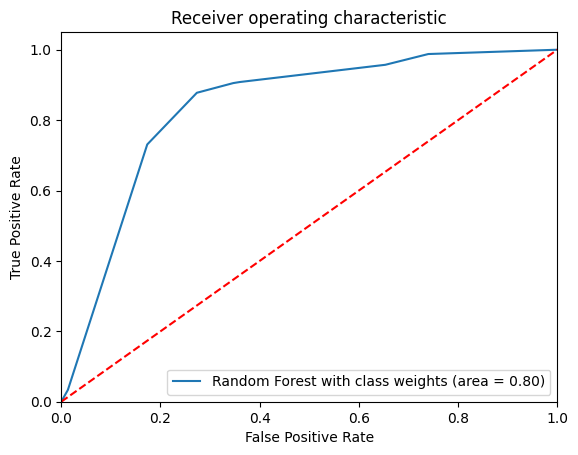

In [182]:
# ROC AUC curve
DT_cw_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, tuned_model_DT_cw.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest with class weights (area = %0.2f)' % DT_cw_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

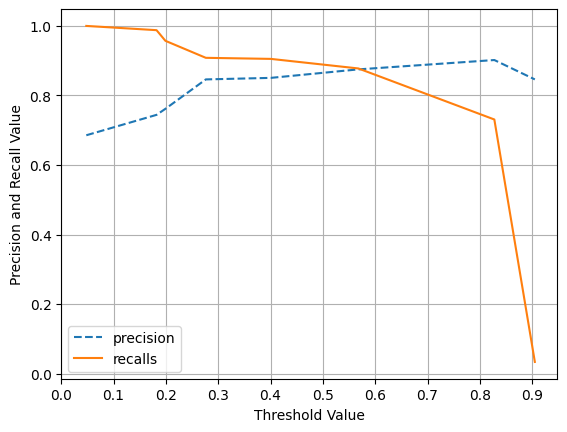

In [183]:
# Precision recall curve
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    threshold_boundary = thresholds.shape[0]
    # plot precision
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    # plot recall
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recalls')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold Value') 
    plt.ylabel('Precision and Recall Value')
    plt.legend()
    plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, tuned_model_DT_cw.predict_proba(X_test)[:,1])

## Feature Importance for the best model

In [192]:
param = {'max_depth':[2,3,4,5,10], 'eta':[0.01,0.03,0.1,0.3,1.0]}

model_XGB_spw = xgb.XGBClassifier(eta=0.1, max_depth=3, objective='binary:logistic', scale_pos_weight=spw)

model_XGB_spw.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

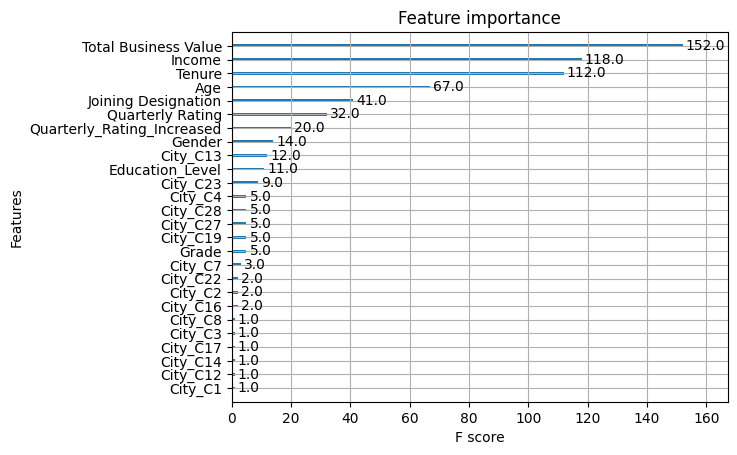

In [193]:
from xgboost import plot_importance
plot_importance(model_XGB_spw, importance_type='weight')

## Actionable Insights & Recommendations

- For XGBoost on imbalanced data, out of all actual 0 the measure of correctly predicted is 77%, and for 1 it is 84% (Recall).
- Here for best model we did not get high Recall for predicting driver  will stay in the organization. This is because of the imbalance in the Target.

- Feature importance gives use following features:
1. Total business value
2. Monthly Income
3. Tenure
4. Age
5. Joining Designation
6. Last Quarterly Rating

- From above feature ranking Organization can focus on below mentioned points to retain the employees:
1. Keep Track of "Total Business Value" generated by driver if it is in negative then driver has high chances of churning.
2. Monitor "Monthly Income" generated by driver, if it is low then driver can easily churn to competitor with best rates and offers. Keep drivers engage with good offers and best market competitive rates.
3. "Tenure" play a vital role deciding the churning rate of the drivers as longer they stay on same grade higher chances are they will churn. This has direct impact on monthly income they generate intern total business value they create.
4. Drivers of age below 35 years old have chances of churning compared to other age band this is because they are more flexible and have outlook for future in the long run to earn more money. Competitors can easily target them with best offers and facilities.
5. Monitor "Quarterly Rating" as this is good indication of how the driver is doing in the work. Below 3 rating drivers have high chances of churning so focus on them by running some training facility to maintain the rating above 3 so total business value will be positive.